In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 150.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
node_features = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/node_features.csv.gz",names=['node_id', "feat_0", 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7'],header=None)
edge_features = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/edge_type_features.csv.gz",names=['edge_type_id', "feat_0", 'feat_1', 'feat_2',],header=None)
test_data = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/input_A.csv.gz",names=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time'],header=None)
edges_train = pd.read_csv('/content/drive/MyDrive/sertifikalarım/Social_Network/edges_train_A.csv.gz',names=['src_id', 'dst_id', 'edge_type', 'timestamp'],header=None)



In [ ]:
test_data

src_id  dst_id  edge_type  start_time    end_time
0           19    2867          4  1498693690  1498840508
1           19    2880          8  1496420943  1496640465
2           19    3990         20  1496308468  1496472407
3           19    5186        234  1496438901  1496571525
4           19    6486        108  1496294861  1496462528
...        ...     ...        ...         ...         ...
199995   69980   49214        176  1494875670  1494996140
199996   69980   52874         33  1498584288  1498694102
199997   69980   55746        209  1497952740  1498081488
199998   69980   60642         71  1497166072  1497356374
199999   69980   64236         69  1495174423  1495378242

[200000 rows x 5 columns]

In [ ]:
edge_features

edge_type_id  feat_0  feat_1  feat_2
0               0      56      16      32
1               1     179      15      70
2               2      65       6      62
3               3     104      12      86
4               4     114       3      20
..            ...     ...     ...     ...
243           243     196      17      98
244           244      21      15      70
245           245      92      10      26
246           246       1       1     109
247           247     156       3      23

[248 rows x 4 columns]

In [ ]:
node_features

node_id  feat_0  feat_1  feat_2  feat_3  feat_4  feat_5  feat_6  feat_7
0            2      29      -1      -1      -1      -1       9      -1      -1
1            5      29      -1      -1      -1      -1      -1      -1      20
2           11      11      -1      -1      -1      -1      -1      -1      20
3           16      13      -1      -1      -1      -1     155      -1      20
4           19      -1      -1      -1      -1      -1      40      -1      -1
...        ...     ...     ...     ...     ...     ...     ...     ...     ...
19437    69967      29      -1      -1      -1      -1      86      -1      20
19438    69971       0      -1      -1      -1      -1      -1      -1      20
19439    69973      29      -1      -1      -1      -1      37      -1      -1
19440    69980      29      -1      -1      -1      -1      59      -1      -1
19441    69983      29       1      -1      -1      -1     219      -1      22

[19442 rows x 9 columns]

In [ ]:
import networkx as nx

In [ ]:
def visualize_graph(snapshot, node_feats, num_nodes_to_plot=100, title="Graph Snapshot"):
    edge_index = snapshot['edge_index'].numpy()


    if edge_index.size == 0:
        print(f"Skipping visualization for {title} (no edges)")
        return


    G = nx.Graph()
    unique_nodes = np.unique(edge_index)

    if len(unique_nodes) > num_nodes_to_plot:
        selected_nodes = np.random.choice(unique_nodes, num_nodes_to_plot, replace=False)
        mask = np.isin(edge_index[0], selected_nodes) & np.isin(edge_index[1], selected_nodes)
        edge_index = edge_index[:, mask]

    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        G.add_edge(src, dst)

    node_colors = node_feats[list(G.nodes)].mean(dim=1).numpy()

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        node_size=100
    )

    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        width=1
    )

    if len(node_colors) > 0:
        plt.colorbar(nodes, label="Node Feature Mean")

    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
unique_nodes = pd.concat([
    edges_train['src_id'],
    edges_train['dst_id'],
    test_data['src_id'],
    test_data['dst_id'],
    node_features['node_id']
]).unique()

node_id_map = {node_id: i for i, node_id in enumerate(sorted(unique_nodes))}

edges_train['src_id'] = edges_train['src_id'].map(node_id_map)
edges_train['dst_id'] = edges_train['dst_id'].map(node_id_map)
node_features['node_id'] = node_features['node_id'].map(node_id_map)
test_data['src_id'] = test_data['src_id'].map(node_id_map)
test_data['dst_id'] = test_data['dst_id'].map(node_id_map)

num_time_bins = 24
edges_train['time_bin'] = pd.cut(edges_train['timestamp'], bins=num_time_bins, labels=False)

In [ ]:
print("NaN values in test_data src_id:", test_data['src_id'].isna().sum())
print("NaN values in test_data dst_id:", test_data['dst_id'].isna().sum())

NaN values in test_data src_id: 0
NaN values in test_data dst_id: 0


In [ ]:
num_time_bins = 24
edges_train['time_bin'] = pd.cut(edges_train['timestamp'], bins=num_time_bins, labels=False)

time_bin_edges = pd.cut(edges_train['timestamp'], bins=num_time_bins, retbins=True)[1]

test_data['start_bin'] = pd.cut(test_data['start_time'], bins=time_bin_edges, labels=False)
test_data['end_bin'] = pd.cut(test_data['end_time'], bins=time_bin_edges, labels=False)

test_data['start_bin'] = test_data['start_bin'].fillna(0).astype(int)
test_data['end_bin'] = test_data['end_bin'].fillna(num_time_bins-1).astype(int)

snapshots = []
for time_bin in range(num_time_bins):
    edges_in_bin = edges_train[edges_train['time_bin'] == time_bin]

    if len(edges_in_bin) == 0:
        continue

    src_nodes = edges_in_bin['src_id'].values
    dst_nodes = edges_in_bin['dst_id'].values

    all_src = np.concatenate([src_nodes, dst_nodes])
    all_dst = np.concatenate([dst_nodes, src_nodes])

    edge_index = torch.tensor(
        np.array([all_src, all_dst]),
        dtype=torch.long
    )

    edge_attr_values = None
    try:
        edge_attr_values = edge_features.loc[edges_in_bin.index].drop('edge_type_id', axis=1).values
        edge_attr = torch.tensor(
            np.concatenate([edge_attr_values, edge_attr_values]),
            dtype=torch.float
        )
    except:
        edge_attr = torch.zeros(len(all_src), edge_features.shape[1]-1)

    snapshots.append({
        'edge_index': edge_index,
        'edge_attr': edge_attr
    })

node_feats = torch.zeros(len(node_id_map), node_features.shape[1]-1)
node_feats[node_features['node_id']] = torch.tensor(
    node_features.drop('node_id', axis=1).values,
    dtype=torch.float
)


In [ ]:
snapshots

[{'edge_index': tensor([[   29,    61,   381,  ...,  7989, 13514, 17112],
          [ 7989,  4016, 12686,  ..., 19389, 19389, 19389]]),
  'edge_attr': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])},
 {'edge_index': tensor([[   29,    29,    29,  ..., 18733, 18681,  7989],
          [ 4194,  7989, 10040,  ..., 18733, 19098, 19118]]),
  'edge_attr': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])},
 {'edge_index': tensor([[  389,   424,   424,  ...,  2383, 17592,  7989],
          [ 9786,    29,  1121,  ..., 19334, 19389, 19427]]),
  'edge_attr': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])},
 {'edge_index': tensor([[   29,    29,   361,  ..., 13496,  3715,  

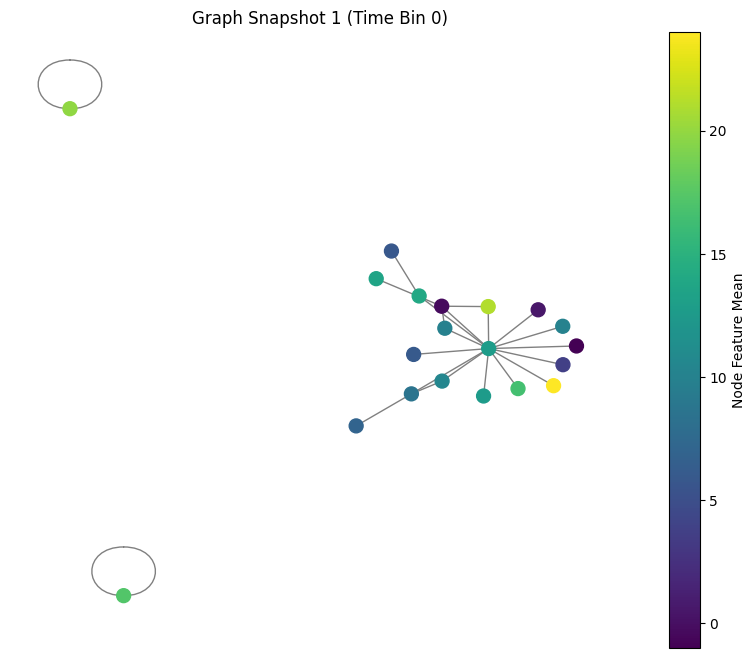

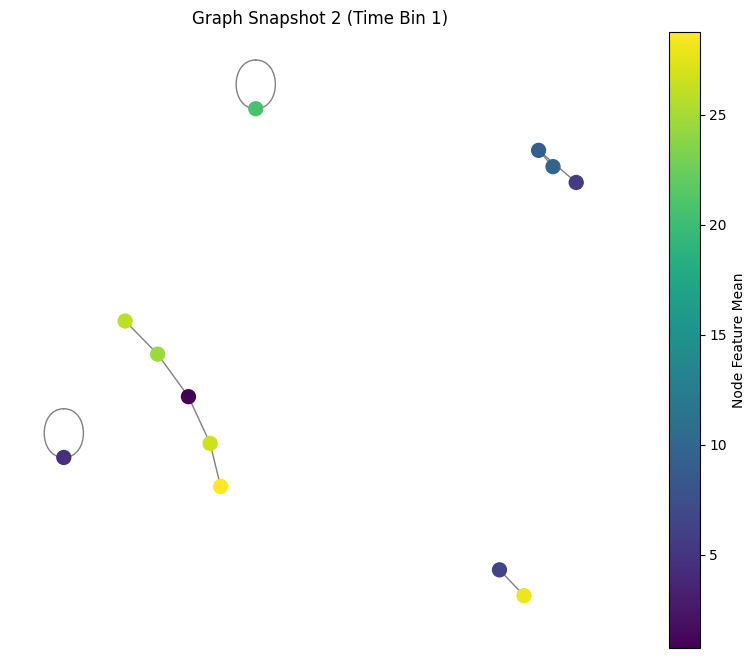

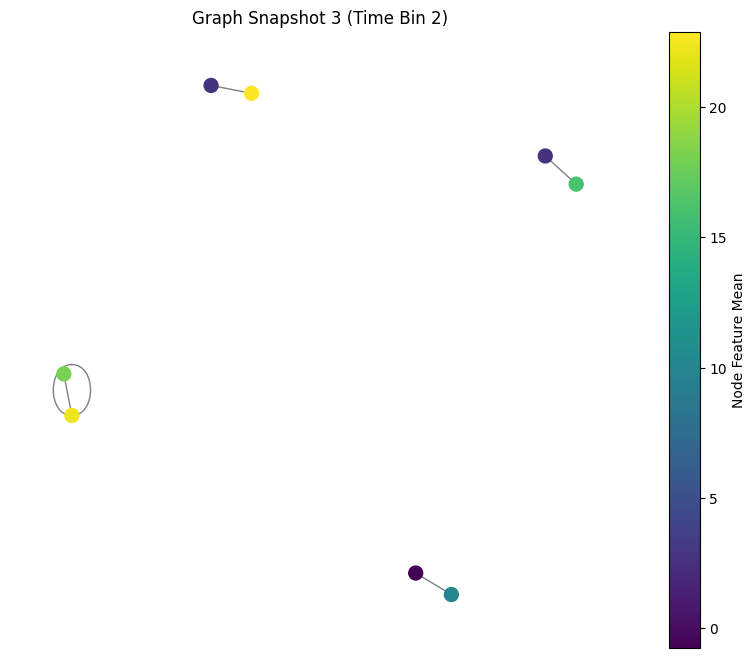

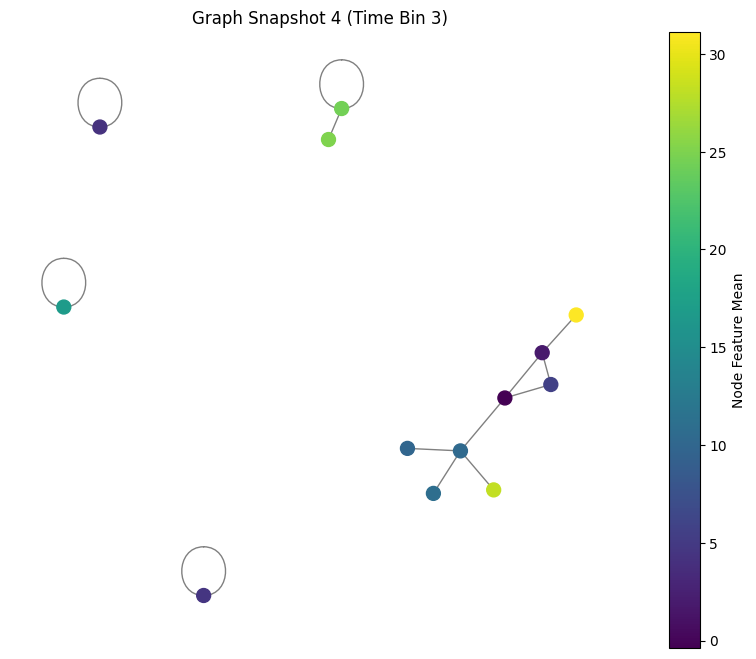

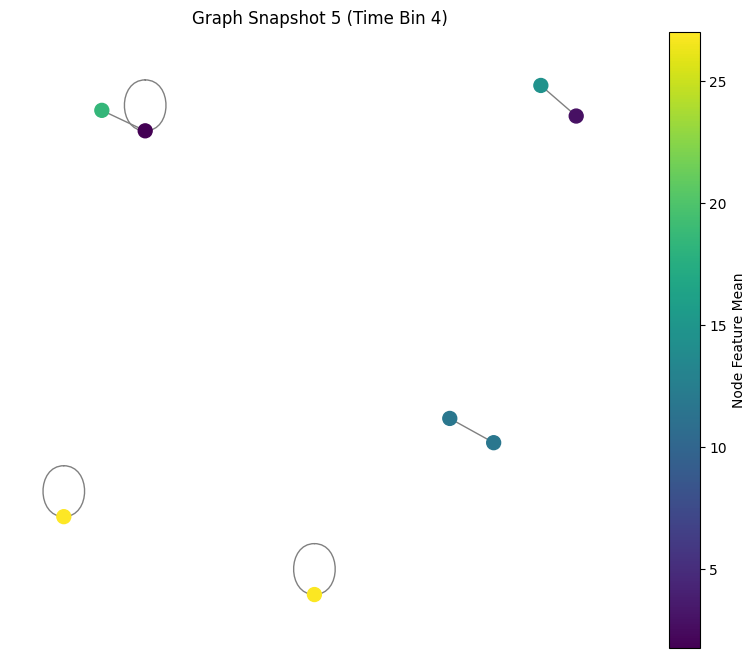

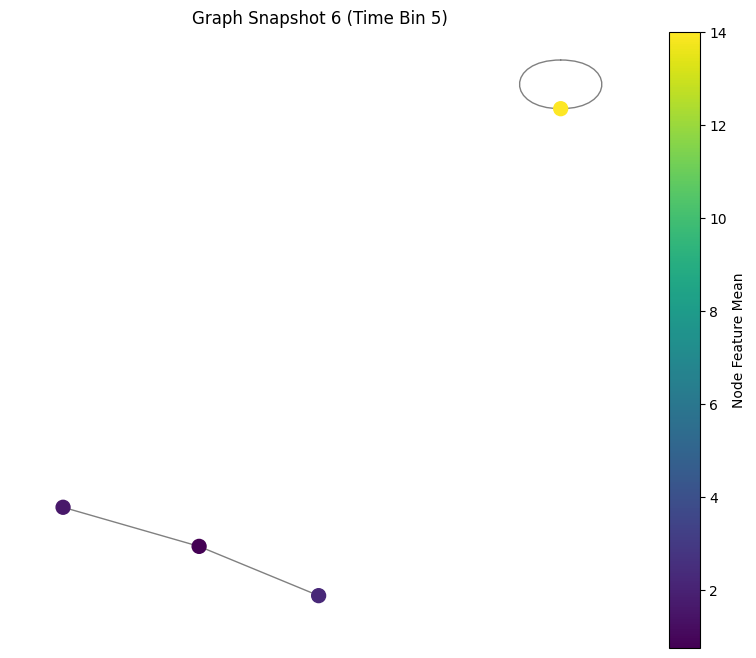

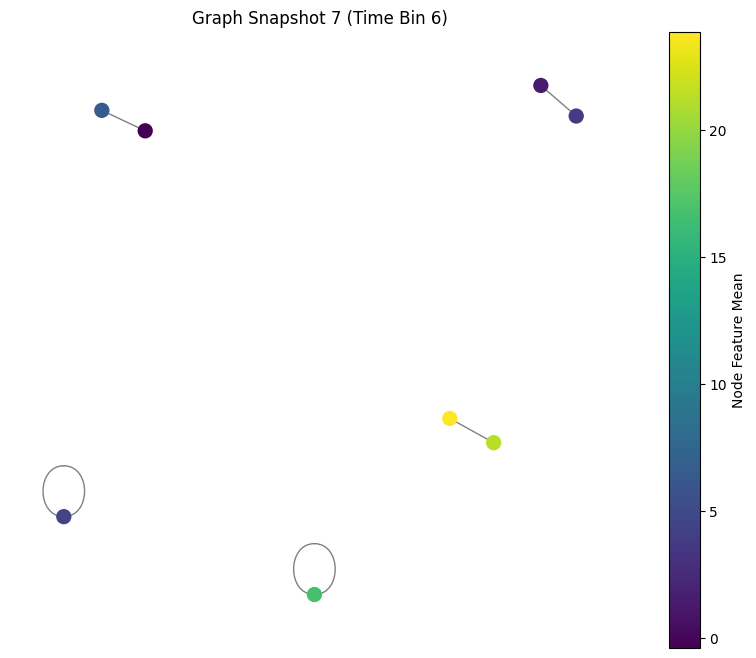

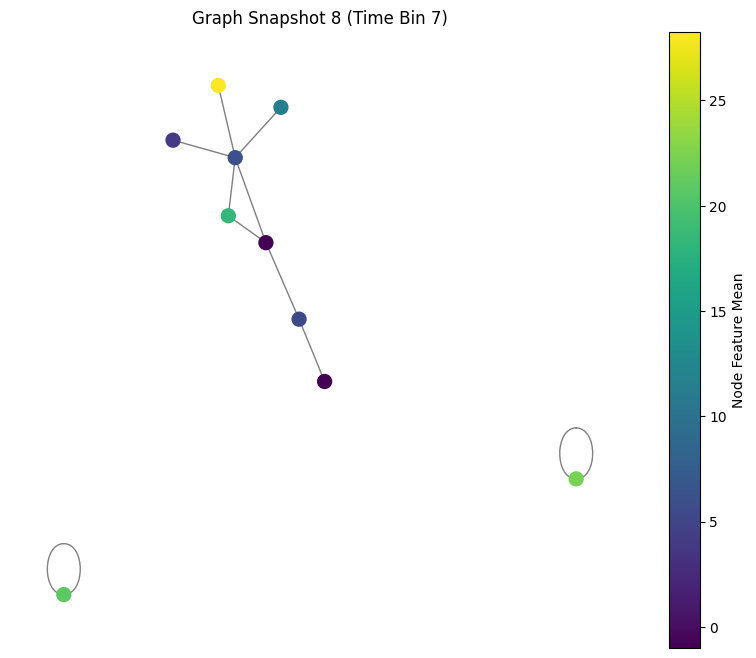

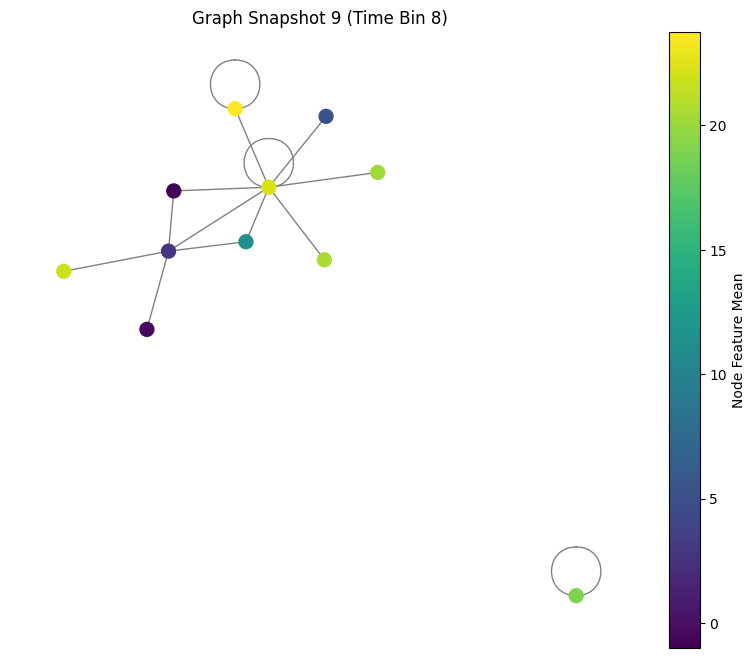

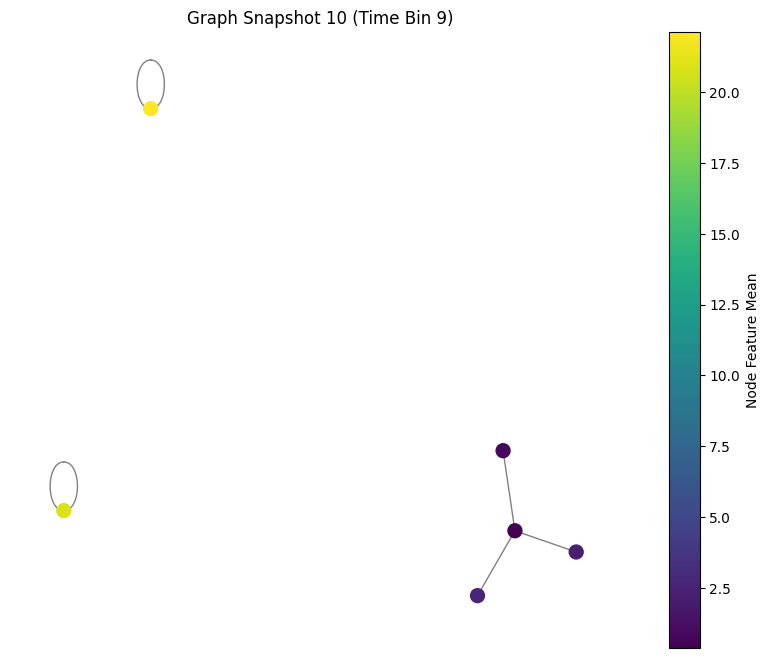

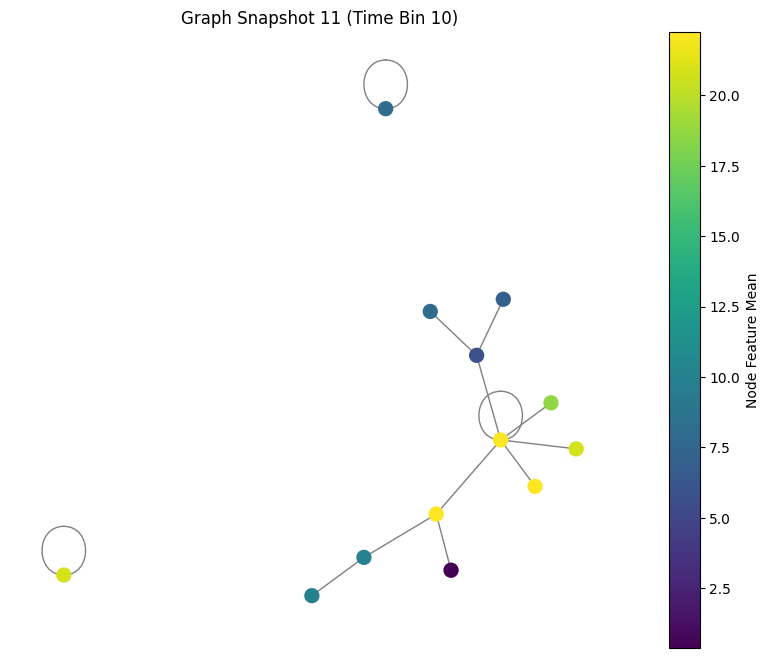

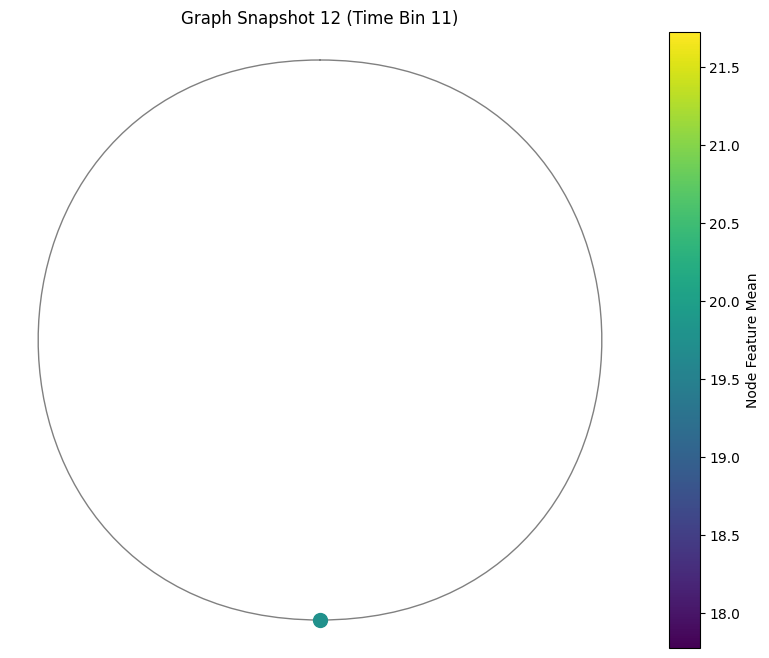

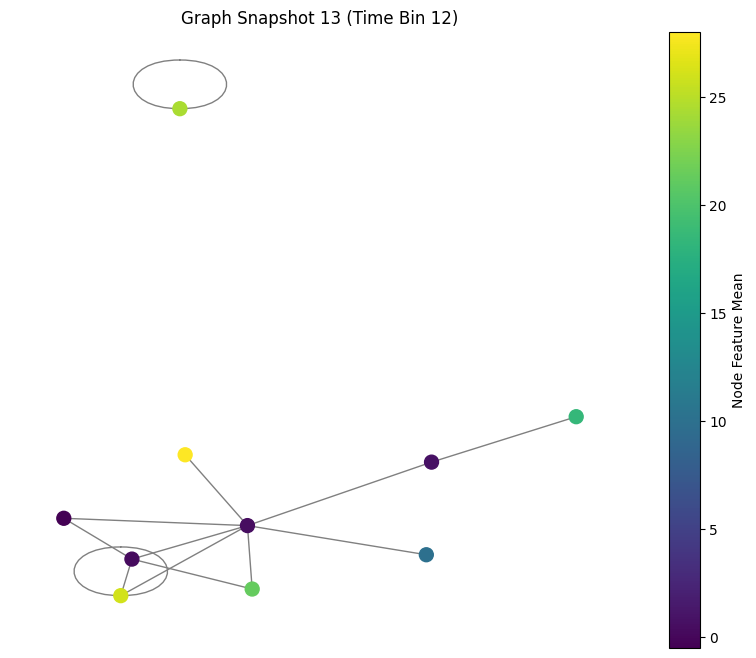

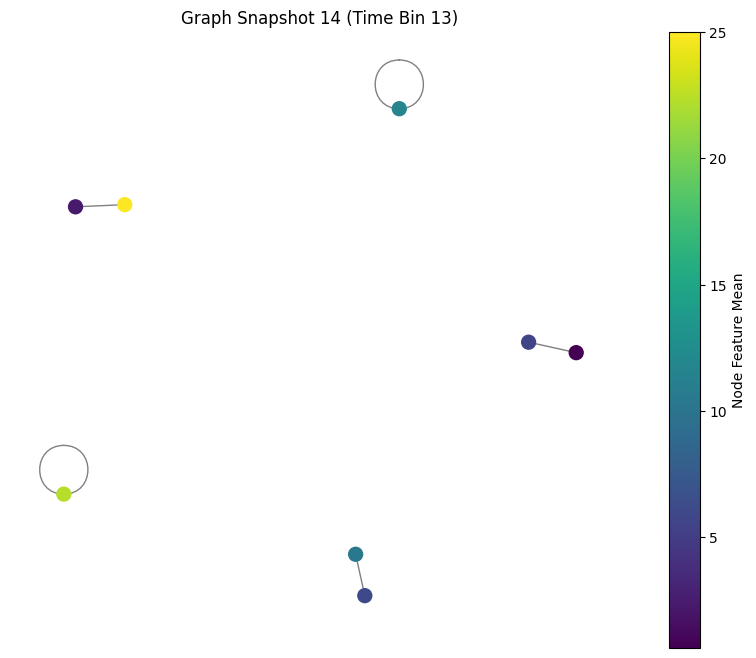

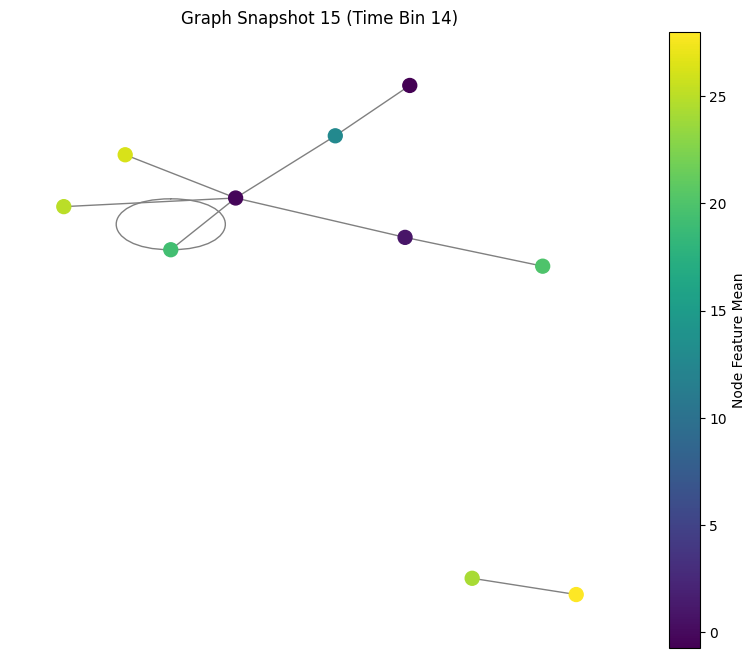

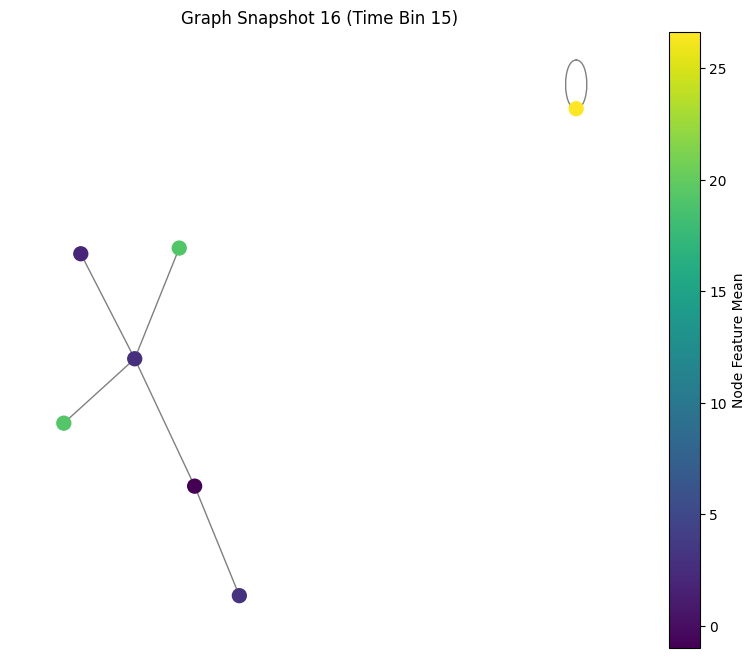

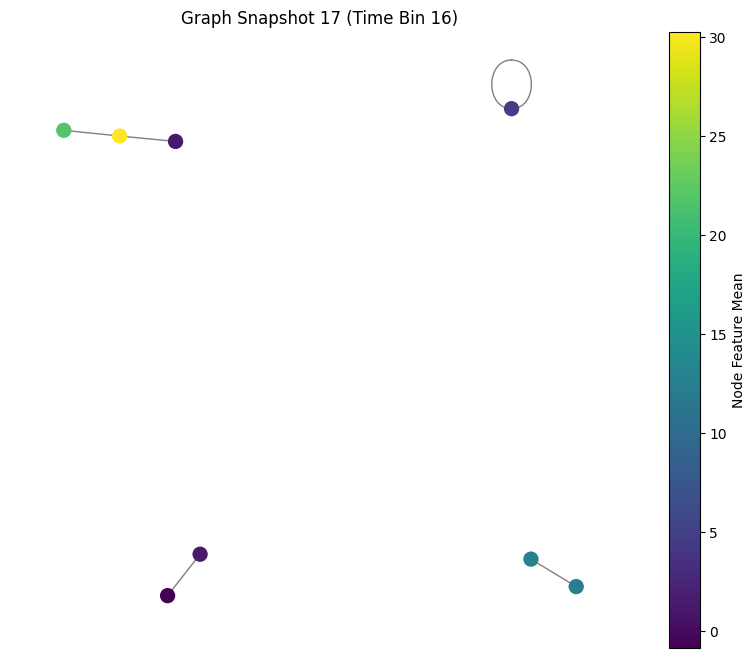

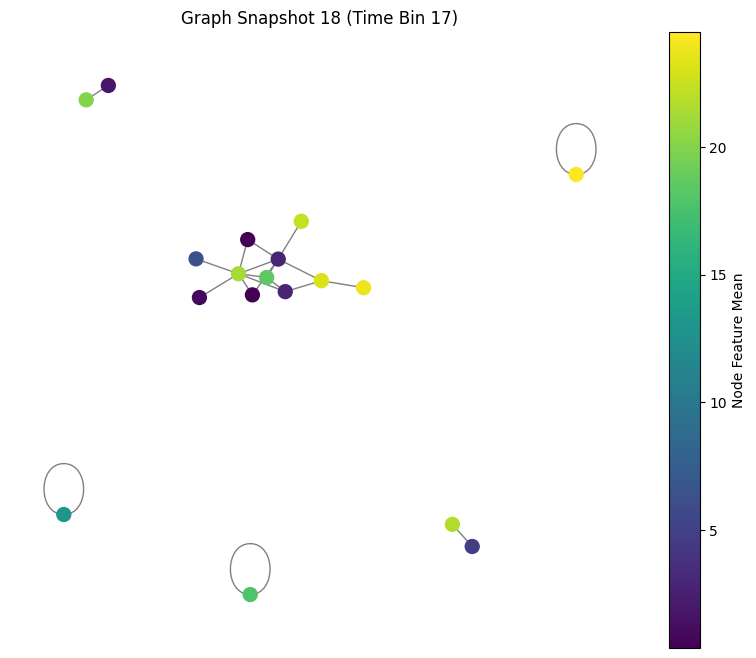

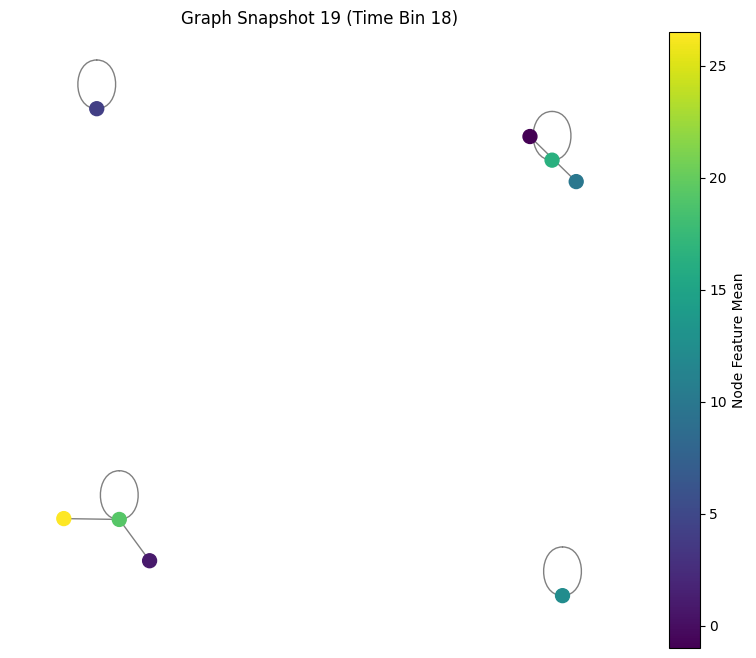

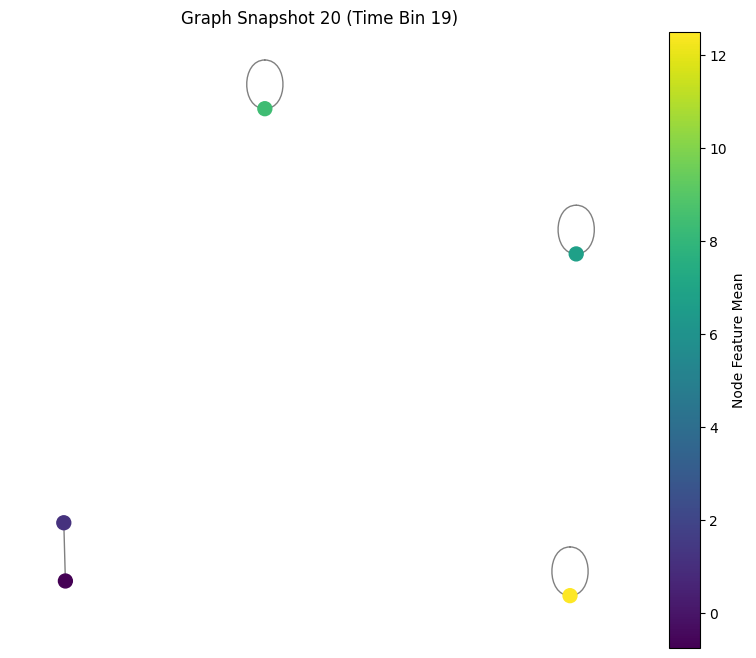

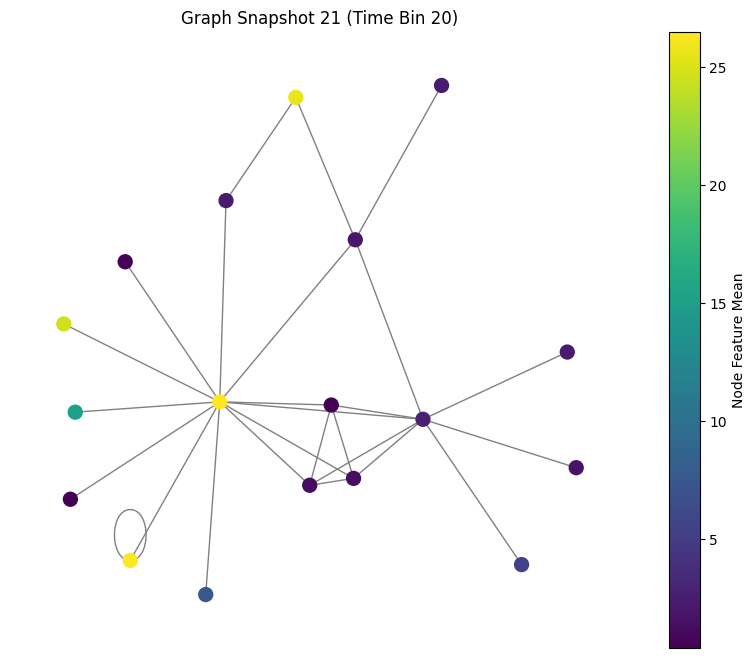

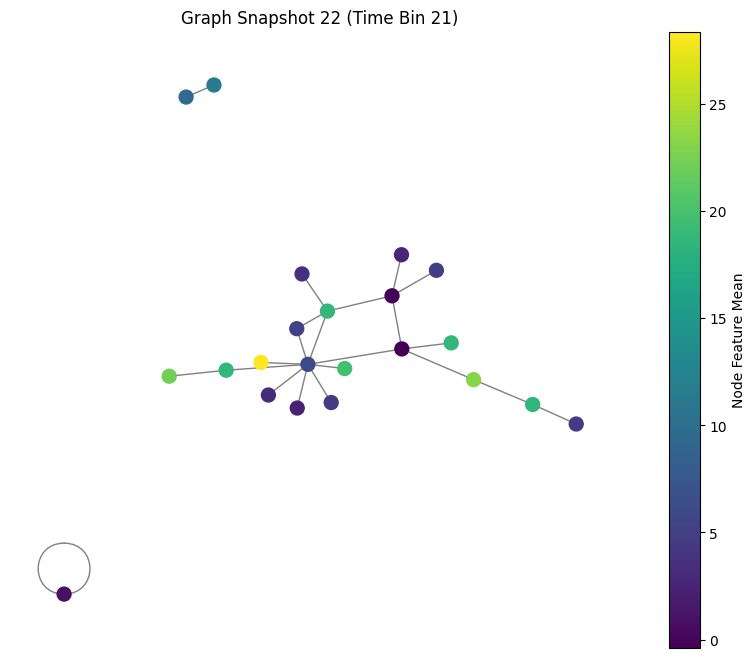

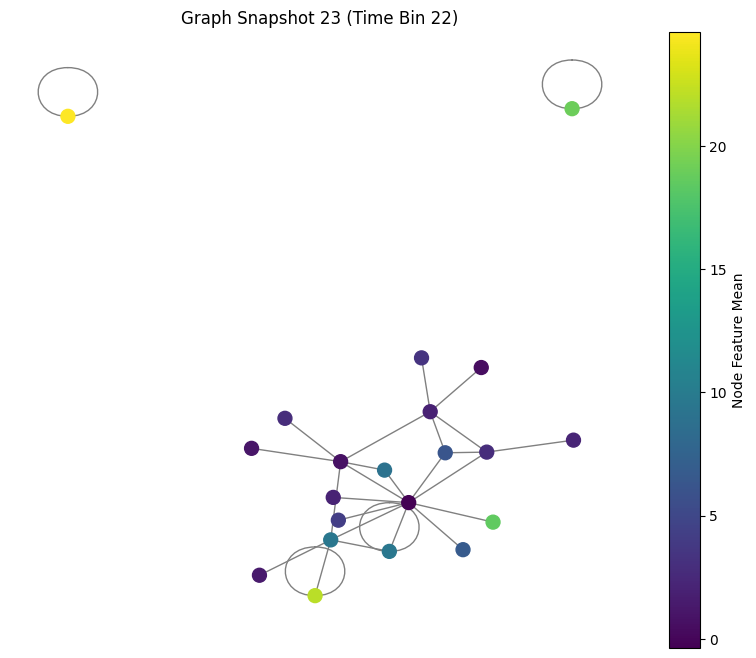

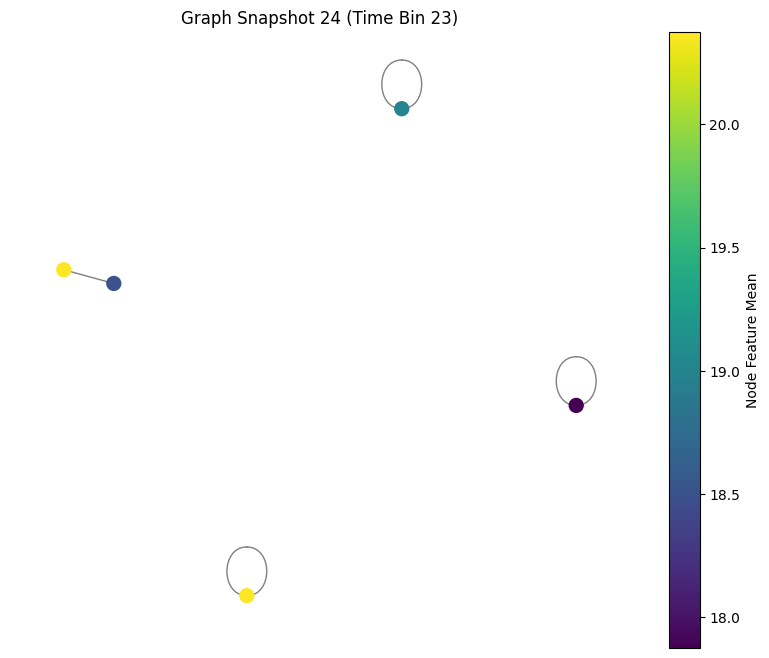

In [ ]:
for i, snapshot in enumerate(snapshots):
    visualize_graph(
        snapshot,
        node_feats,
        title=f"Graph Snapshot {i+1} (Time Bin {i})"
    )

In [ ]:
test_data

src_id  dst_id  edge_type  start_time    end_time  start_bin  end_bin
0            4     799          4  1498693690  1498840508          0       23
1            4     803          8  1496420943  1496640465          0       23
2            4    1132         20  1496308468  1496472407          0       23
3            4    1456        234  1496438901  1496571525          0       23
4            4    1813        108  1496294861  1496462528          0       23
...        ...     ...        ...         ...         ...        ...      ...
199995   19440   13632        176  1494875670  1494996140          0       23
199996   19440   14635         33  1498584288  1498694102          0       23
199997   19440   15424        209  1497952740  1498081488          0       23
199998   19440   16756         71  1497166072  1497356374          0       23
199999   19440   17824         69  1495174423  1495378242          0       23

[200000 rows x 7 columns]

In [ ]:
def visualize_embeddings(model, batch, node_feats, title="Embedding Visualization"):
    model.eval()

    with torch.no_grad():
        node_embeddings = model(
            node_feats,
            batch['edge_index'],
            batch['edge_attr'],
            batch['timestamps']
        )

        src, dst = batch['edge_index']
        pos_pairs = torch.stack([node_embeddings[src], node_embeddings[dst]], dim=1)

        neg_edge_index = negative_sampling(
            edge_index=batch['edge_index'],
            num_nodes=len(node_feats),
            num_neg_samples=min(1000, len(src))
        )
        neg_src, neg_dst = neg_edge_index
        neg_pairs = torch.stack([node_embeddings[neg_src], node_embeddings[neg_dst]], dim=1)

        from sklearn.manifold import TSNE

        max_samples = 1000
        pos_sample_idx = np.random.choice(len(pos_pairs), min(max_samples, len(pos_pairs)), replace=False)
        neg_sample_idx = np.random.choice(len(neg_pairs), min(max_samples, len(neg_pairs)), replace=False)

        pos_pairs_sample = pos_pairs[pos_sample_idx].reshape(-1, node_embeddings.shape[1])
        neg_pairs_sample = neg_pairs[neg_sample_idx].reshape(-1, node_embeddings.shape[1])


        combined_pairs = torch.cat([pos_pairs_sample, neg_pairs_sample], dim=0)
        pair_labels = torch.cat([
            torch.ones(len(pos_pairs_sample)),
            torch.zeros(len(neg_pairs_sample))
        ])


        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(combined_pairs)-1))
        embedded = tsne.fit_transform(combined_pairs.cpu().numpy())

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            embedded[:, 0],
            embedded[:, 1],
            c=pair_labels,
            cmap='coolwarm',
            alpha=0.6,
            s=50
        )

        plt.colorbar(scatter, label="Edge Exists (1) / Doesn't Exist (0)")
        plt.title(title)
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(alpha=0.3)
        plt.show()

        pos_scores = F.cosine_similarity(node_embeddings[src], node_embeddings[dst]).mean().item()
        neg_scores = F.cosine_similarity(node_embeddings[neg_src], node_embeddings[neg_dst]).mean().item()

        print(f"Average similarity for positive pairs: {pos_scores:.4f}")
        print(f"Average similarity for negative pairs: {neg_scores:.4f}")
        print(f"Separation (pos - neg): {pos_scores - neg_scores:.4f}")


In [ ]:
import math

In [ ]:
class TimeEncoder(nn.Module):
    def __init__(self, dimension, max_time=10000):
        super(TimeEncoder, self).__init__()
        self.dimension = dimension
        self.max_time = max_time
        self.basis_freq = nn.Parameter(torch.zeros(dimension))
        self.phase = nn.Parameter(torch.zeros(dimension))

        nn.init.uniform_(self.basis_freq, 0, 0.1)
        nn.init.uniform_(self.phase, 0, 0.1)

    def forward(self, timestamps):
        if not isinstance(timestamps, torch.Tensor):
            timestamps = torch.tensor(timestamps, dtype=torch.float)

        timestamps = timestamps.unsqueeze(-1) / self.max_time

        time_encoding = torch.sin(timestamps * self.basis_freq + self.phase)
        return time_encoding

class TGAT(nn.Module):
    def __init__(self, num_nodes, node_feat_dim, edge_feat_dim, time_dim=8, num_layers=2, heads=2, dropout=0.4,
                 embedding_l2_reg=0.001, attention_dropout=0.3):
        super(TGAT, self).__init__()
        self.num_nodes = num_nodes
        self.node_feat_dim = node_feat_dim
        self.time_dim = time_dim
        self.num_layers = num_layers
        self.heads = heads
        self.embedding_l2_reg = embedding_l2_reg
        self.reg_loss = 0.0


        self.time_encoder = TimeEncoder(time_dim)

        self.node_feat_transform = nn.Linear(node_feat_dim, node_feat_dim)

        self.edge_feat_transform = nn.Linear(edge_feat_dim + time_dim, edge_feat_dim)

        self.gat_layers = nn.ModuleList()
        for i in range(num_layers):
            in_dim = node_feat_dim if i == 0 else node_feat_dim * heads
            self.gat_layers.append(
                GATConv(
                    in_dim, node_feat_dim, heads=heads,
                    edge_dim=edge_feat_dim, add_self_loops=True,
                    dropout=attention_dropout
                )
            )

        self.final_proj = nn.Linear(node_feat_dim * heads, node_feat_dim)

        self.dropout = nn.Dropout(dropout)

        self.layer_norm = nn.LayerNorm(node_feat_dim)

    def forward(self, node_feats, edge_index, edge_attr, timestamps):
        node_feats = F.relu(self.node_feat_transform(node_feats))

        time_encoding = self.time_encoder(timestamps)


        if len(timestamps) != edge_attr.size(0):
            if len(timestamps) == 1:
                time_encoding_repeated = time_encoding.repeat(edge_attr.size(0), 1)
            else:
                max_batch_size = 10000
                time_encoding_repeated = []

                for i in range(0, edge_attr.size(0), max_batch_size):
                    end_idx = min(i + max_batch_size, edge_attr.size(0))
                    batch_size = end_idx - i

                    batch_time_indices = torch.arange(i, end_idx) % len(timestamps)
                    batch_encodings = time_encoding[batch_time_indices]
                    time_encoding_repeated.append(batch_encodings)

                time_encoding_repeated = torch.cat(time_encoding_repeated, dim=0)
        else:
            time_encoding_repeated = time_encoding

        edge_attr_with_time = torch.cat([edge_attr, time_encoding_repeated], dim=1)
        edge_attr_transformed = F.relu(self.edge_feat_transform(edge_attr_with_time))

        h = node_feats
        for i, gat_layer in enumerate(self.gat_layers):
            h = gat_layer(h, edge_index, edge_attr=edge_attr_transformed)
            h = self.dropout(h)
            if i < self.num_layers - 1:
                h = F.relu(h)

        h = self.final_proj(h)

        embedding_norm = torch.norm(h, p=2, dim=1).mean()
        self.reg_loss = self.embedding_l2_reg * embedding_norm

        return h

In [ ]:
def create_temporal_batches(edges_train, node_feats, edge_features, num_batches=10):

    edges_sorted = edges_train.sort_values('timestamp')

    batch_size = min(len(edges_sorted) // num_batches, 10000)
    batches = []

    for i in range(0, len(edges_sorted), batch_size):
        end_idx = min(i + batch_size, len(edges_sorted))
        batch_edges = edges_sorted.iloc[i:end_idx]

        src_nodes = batch_edges['src_id'].values
        dst_nodes = batch_edges['dst_id'].values

        all_src = np.concatenate([src_nodes, dst_nodes])
        all_dst = np.concatenate([dst_nodes, src_nodes])

        edge_index = torch.tensor(
            np.array([all_src, all_dst]),
            dtype=torch.long
        )

        try:
            edge_attr_values = edge_features.loc[batch_edges.index].drop('edge_type_id', axis=1).values
            edge_attr = torch.tensor(
                np.concatenate([edge_attr_values, edge_attr_values]),
                dtype=torch.float
            )
        except:
            edge_attr = torch.zeros(len(all_src), edge_features.shape[1]-1)

        mean_timestamp = batch_edges['timestamp'].mean()
        timestamps = torch.tensor([mean_timestamp], dtype=torch.float)

        batches.append({
            'edge_index': edge_index,
            'edge_attr': edge_attr,
            'timestamps': timestamps,
            'batch_edges': batch_edges
        })

    return batches

In [ ]:
temporal_batches = create_temporal_batches(edges_train, node_feats, edge_features, num_batches=10)

In [ ]:
model = TGAT(
    num_nodes=len(node_id_map),
    node_feat_dim=8,
    edge_feat_dim=edge_features.shape[1]-1,
    time_dim=8,
    num_layers=1,
    heads=1,
    dropout=0.5,
    embedding_l2_reg=0.003,
    attention_dropout=0.4
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=3e-4)



In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=1, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from torch_geometric.utils import negative_sampling

Epoch 001 | Loss: 0.5609 | Accuracy: 0.7702 | AUC: 0.9275 | Patience: 0/5
Epoch 002 | Loss: 0.5398 | Accuracy: 0.7873 | AUC: 0.9331 | Patience: 0/5
Epoch 003 | Loss: 0.5393 | Accuracy: 0.7851 | AUC: 0.9332 | Patience: 1/5
Epoch 004 | Loss: 0.5389 | Accuracy: 0.7862 | AUC: 0.9330 | Patience: 2/5
Epoch 005 | Loss: 0.5389 | Accuracy: 0.7864 | AUC: 0.9324 | Patience: 3/5
Epoch 006 | Loss: 0.5388 | Accuracy: 0.7865 | AUC: 0.9324 | Patience: 0/5
Epoch 007 | Loss: 0.5386 | Accuracy: 0.7866 | AUC: 0.9325 | Patience: 1/5
Epoch 008 | Loss: 0.5386 | Accuracy: 0.7873 | AUC: 0.9323 | Patience: 2/5
Epoch 009 | Loss: 0.5386 | Accuracy: 0.7873 | AUC: 0.9323 | Patience: 3/5
Epoch 010 | Loss: 0.5357 | Accuracy: 0.7928 | AUC: 0.9316 | Patience: 0/5
Epoch 011 | Loss: 0.5355 | Accuracy: 0.7936 | AUC: 0.9313 | Patience: 1/5
Epoch 012 | Loss: 0.5355 | Accuracy: 0.7935 | AUC: 0.9314 | Patience: 2/5
Epoch 013 | Loss: 0.5353 | Accuracy: 0.7937 | AUC: 0.9313 | Patience: 3/5
Epoch 014 | Loss: 0.5353 | Accuracy: 0

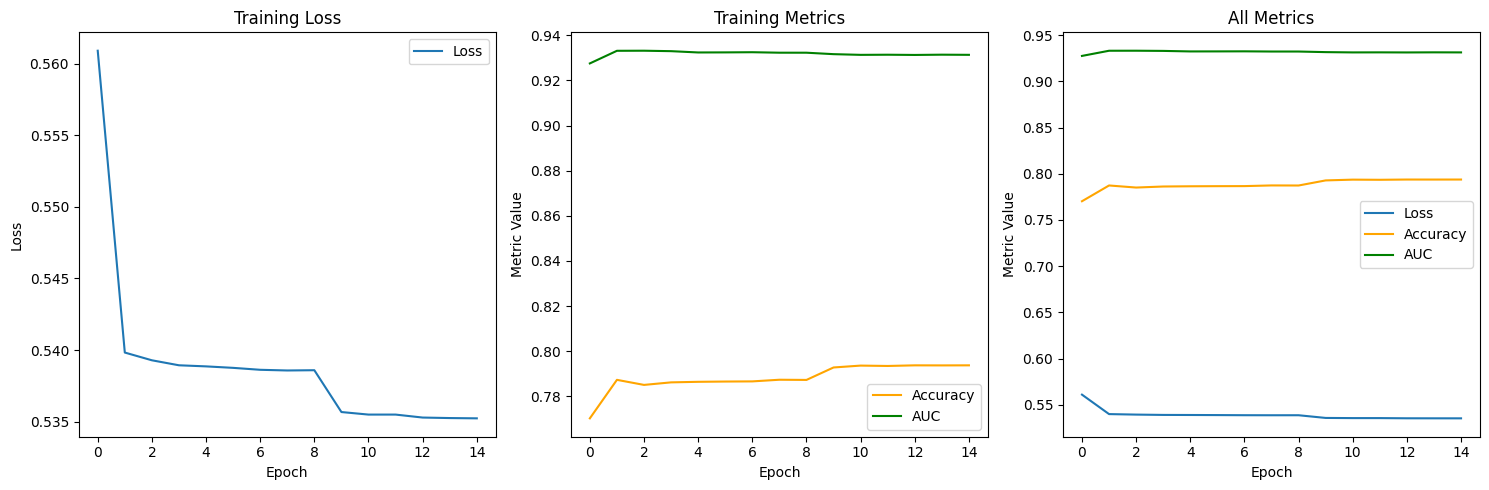

In [ ]:
train_losses = []
train_accuracies = []
train_aucs = []
best_loss = float('inf')
patience = 5
no_improve_epochs = 0
min_delta = 0.001

for epoch in range(100):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_auc = 0

    np.random.shuffle(temporal_batches)

    for batch in temporal_batches:
        optimizer.zero_grad()

        node_embeddings = model(
            node_feats,
            batch['edge_index'],
            batch['edge_attr'],
            batch['timestamps']
        )

        src, dst = batch['edge_index']
        pos_scores = F.cosine_similarity(node_embeddings[src], node_embeddings[dst]) * 5.0

        neg_edge_index = negative_sampling(
            edge_index=batch['edge_index'],
            num_nodes=len(node_feats),
            num_neg_samples=len(src),
            method='sparse'
        )

        neg_src, neg_dst = neg_edge_index
        neg_scores = F.cosine_similarity(node_embeddings[neg_src], node_embeddings[neg_dst]) * 5.0

        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])

        margin = 0.8
        contrastive_loss = torch.mean(torch.relu(margin - (pos_scores.mean() - neg_scores.mean())))

        bce_loss = F.binary_cross_entropy_with_logits(scores, labels)
        loss = bce_loss + 0.5 * model.reg_loss + 0.2 * contrastive_loss

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()


        with torch.no_grad():
            predictions = (torch.sigmoid(scores) > 0.5).float()
            accuracy = (predictions == labels).float().mean()

            from sklearn.metrics import roc_auc_score
            probs = torch.sigmoid(scores).cpu().numpy()
            y_true = labels.cpu().numpy()
            try:
                auc = roc_auc_score(y_true, probs)
            except:
                auc = 0.5

        epoch_loss += loss.item()
        epoch_acc += accuracy.item()
        epoch_auc += auc

    avg_loss = epoch_loss / len(temporal_batches)
    avg_acc = epoch_acc / len(temporal_batches)
    avg_auc = epoch_auc / len(temporal_batches)
    scheduler.step(avg_loss)

    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)
    train_aucs.append(avg_auc)

    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_tgat_model.pth')
    else:
        no_improve_epochs += 1

    print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f} | AUC: {avg_auc:.4f} | Patience: {no_improve_epochs}/{patience}")

    if no_improve_epochs >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}!")
        break

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Accuracy', color='orange')
plt.plot(train_aucs, label='AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy', color='orange')
plt.plot(train_aucs, label='AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('All Metrics')
plt.legend()

plt.tight_layout()
plt.show()


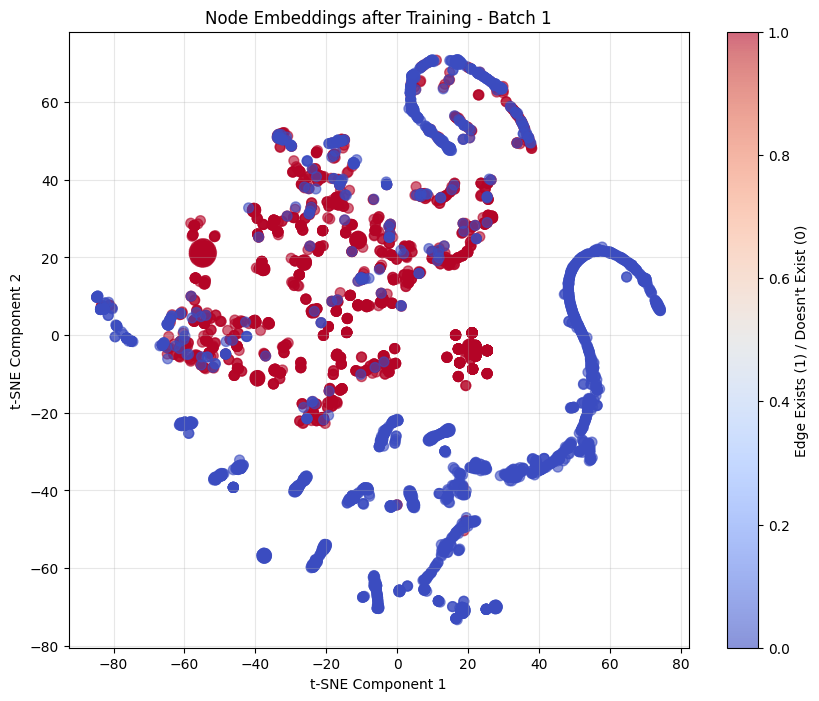

Average similarity for positive pairs: 0.9510
Average similarity for negative pairs: 0.1961
Separation (pos - neg): 0.7549


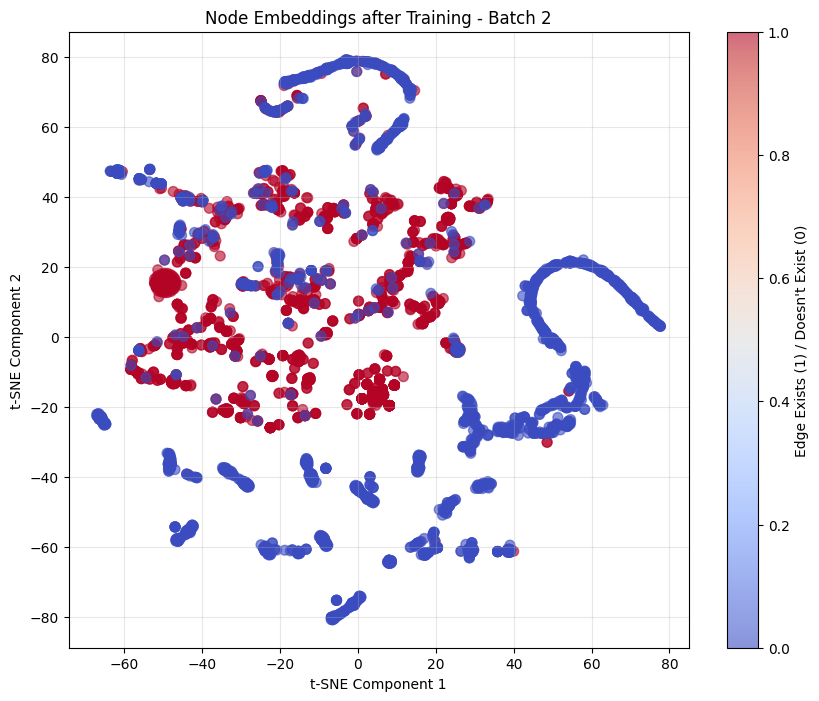

Average similarity for positive pairs: 0.9549
Average similarity for negative pairs: 0.1394
Separation (pos - neg): 0.8154


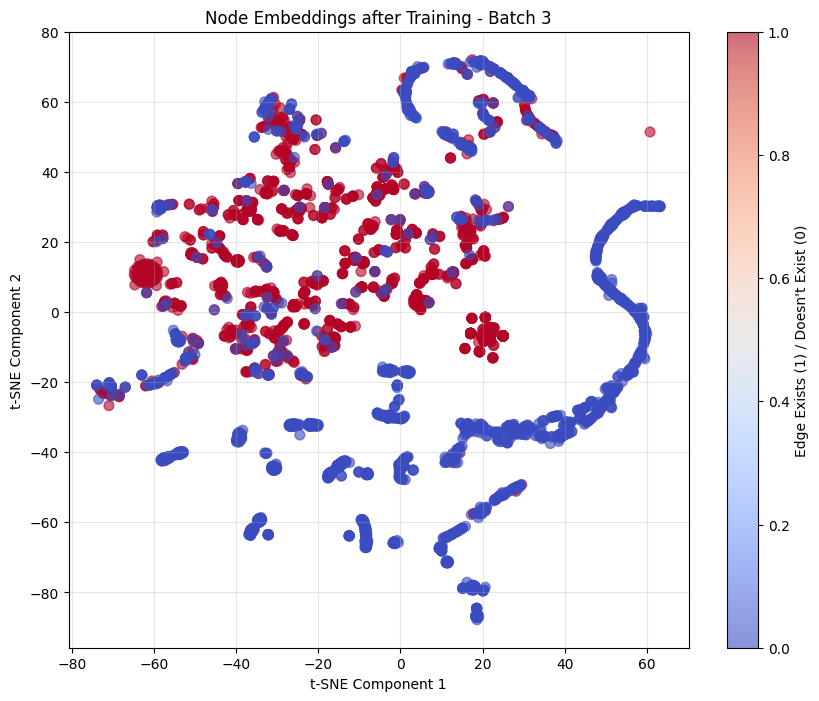

Average similarity for positive pairs: 0.9502
Average similarity for negative pairs: 0.1456
Separation (pos - neg): 0.8046


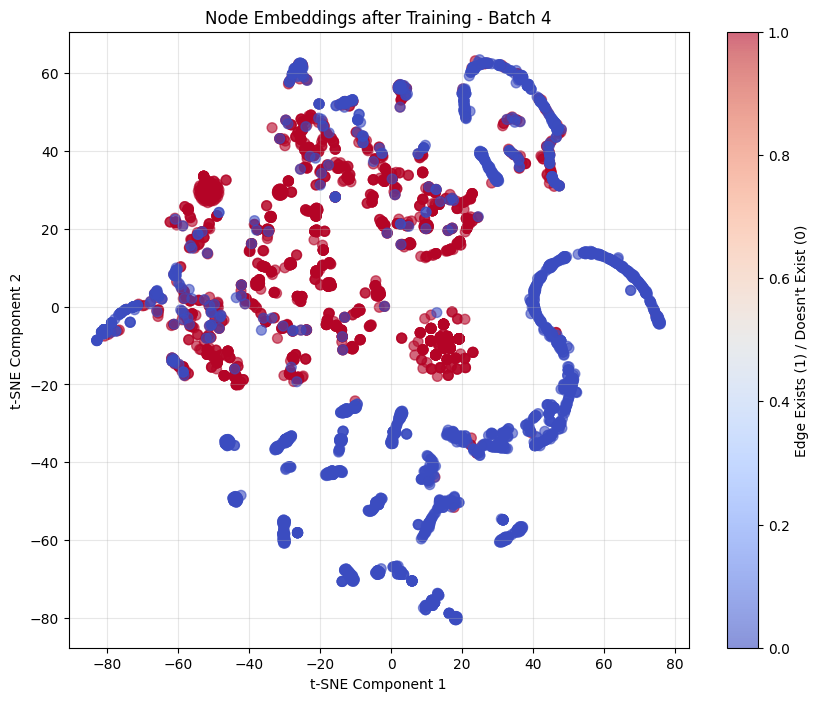

Average similarity for positive pairs: 0.9497
Average similarity for negative pairs: 0.1685
Separation (pos - neg): 0.7812


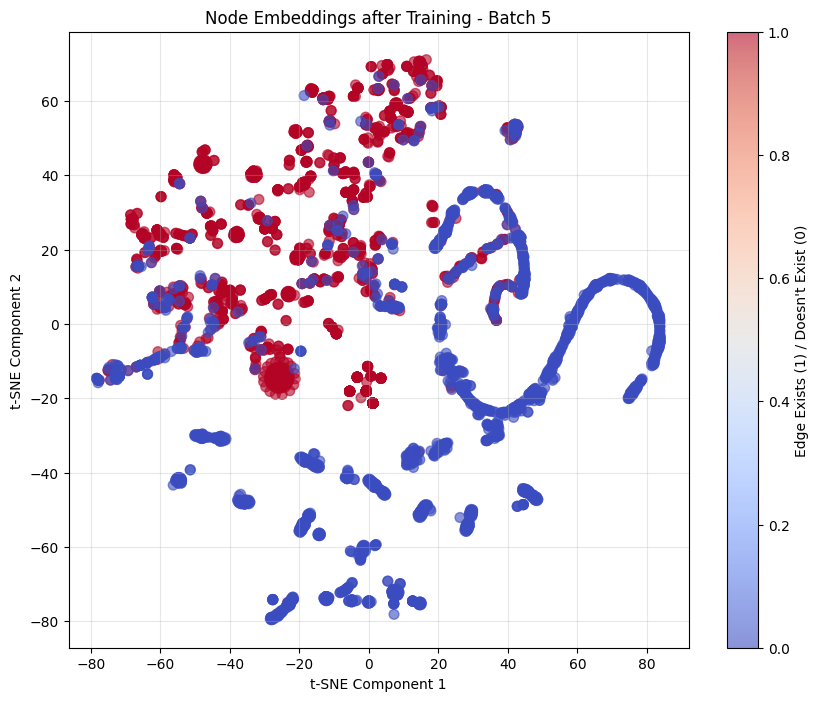

Average similarity for positive pairs: 0.9527
Average similarity for negative pairs: 0.1607
Separation (pos - neg): 0.7920


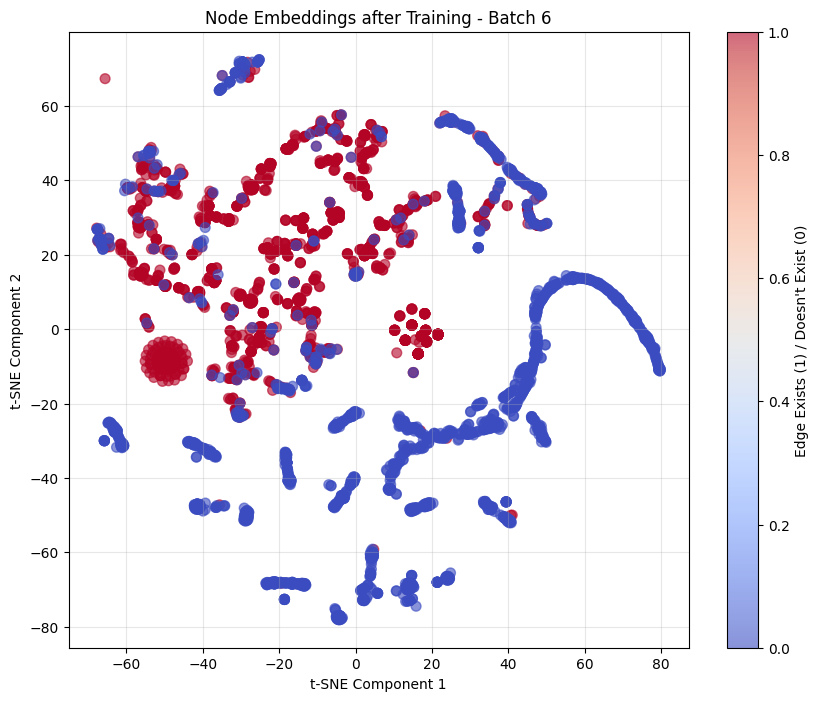

Average similarity for positive pairs: 0.9563
Average similarity for negative pairs: 0.1528
Separation (pos - neg): 0.8035


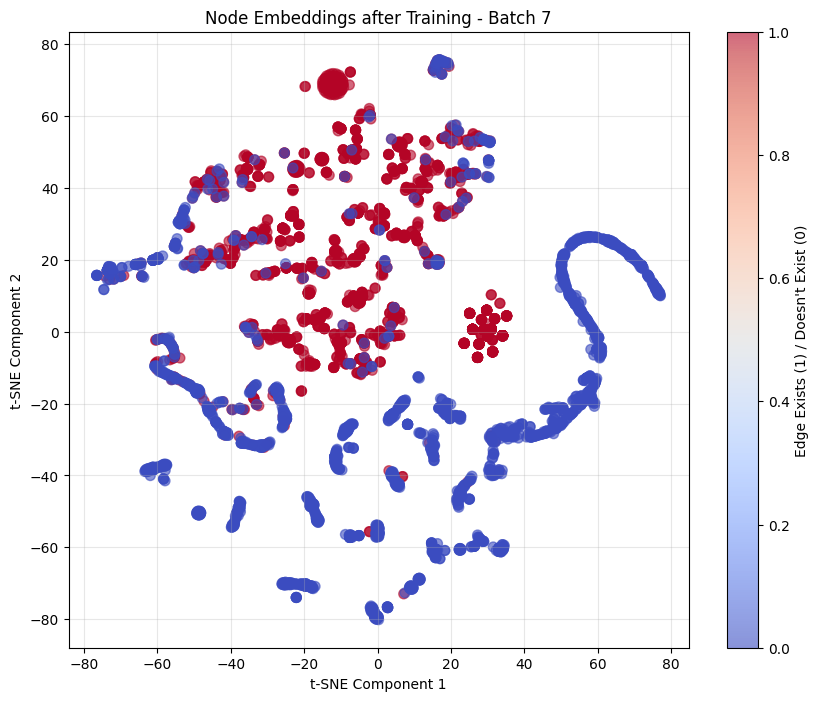

Average similarity for positive pairs: 0.9535
Average similarity for negative pairs: 0.1433
Separation (pos - neg): 0.8102


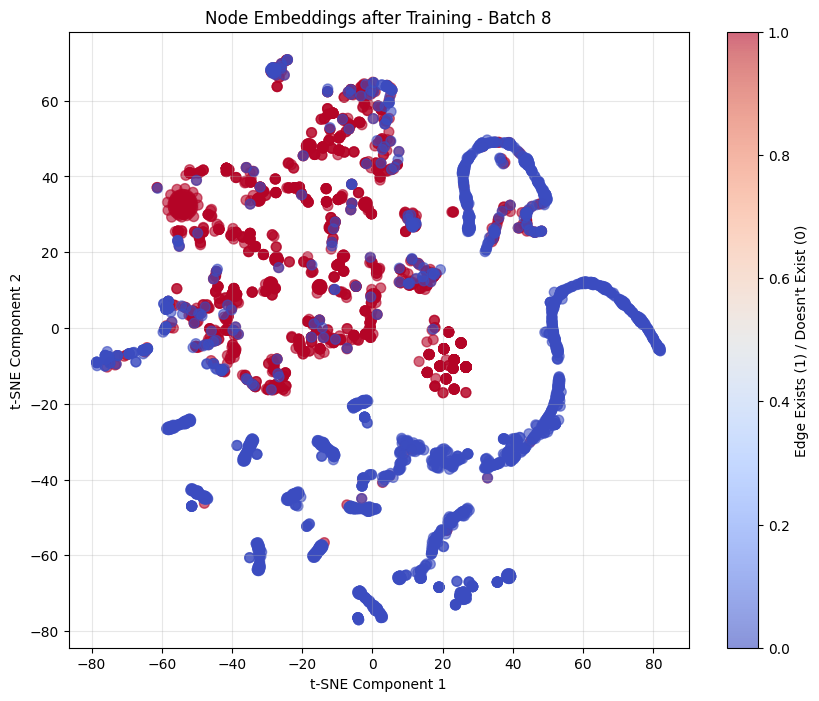

Average similarity for positive pairs: 0.9526
Average similarity for negative pairs: 0.1348
Separation (pos - neg): 0.8178


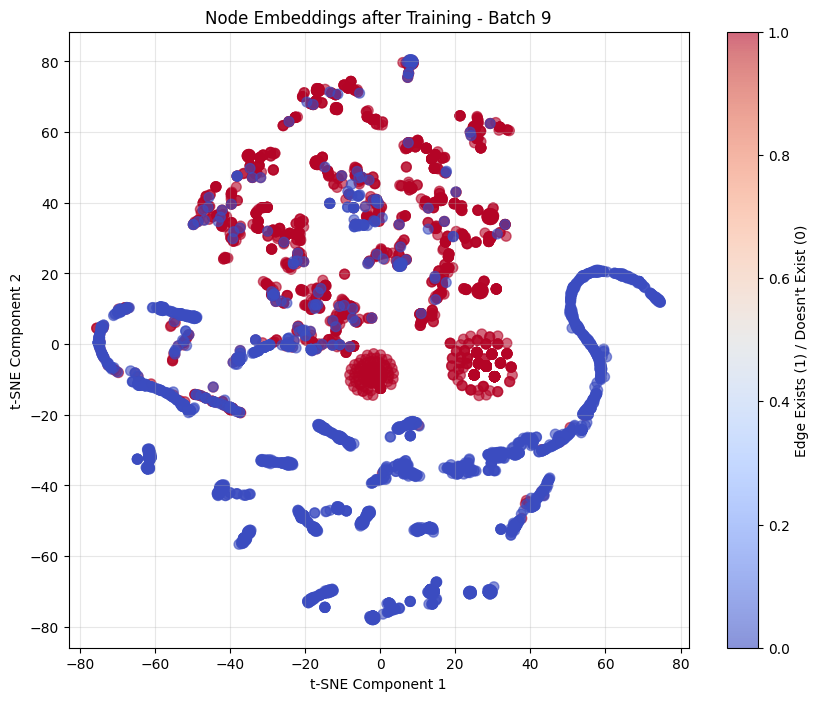

Average similarity for positive pairs: 0.9516
Average similarity for negative pairs: 0.1896
Separation (pos - neg): 0.7620


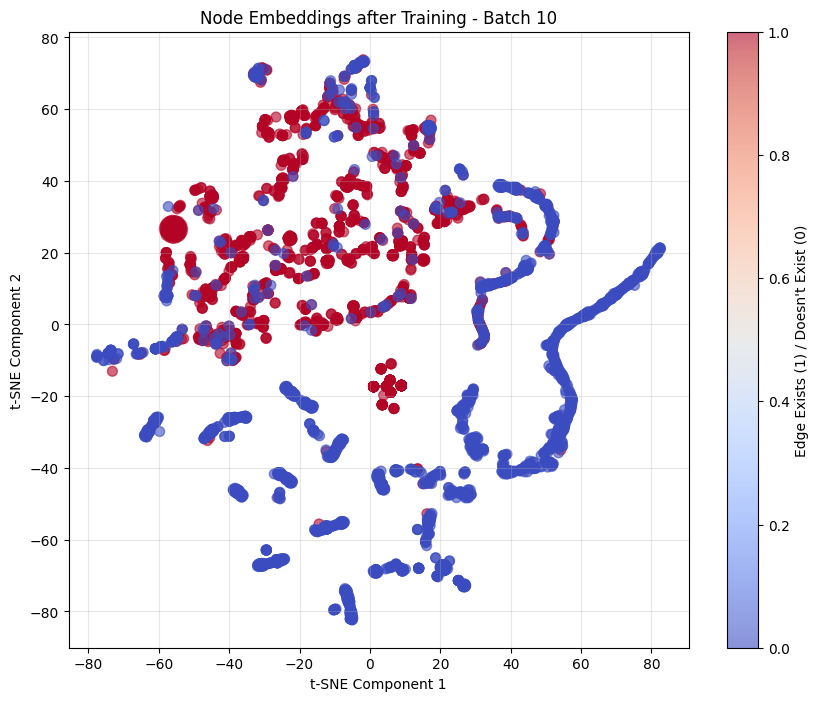

Average similarity for positive pairs: 0.9541
Average similarity for negative pairs: 0.1287
Separation (pos - neg): 0.8254


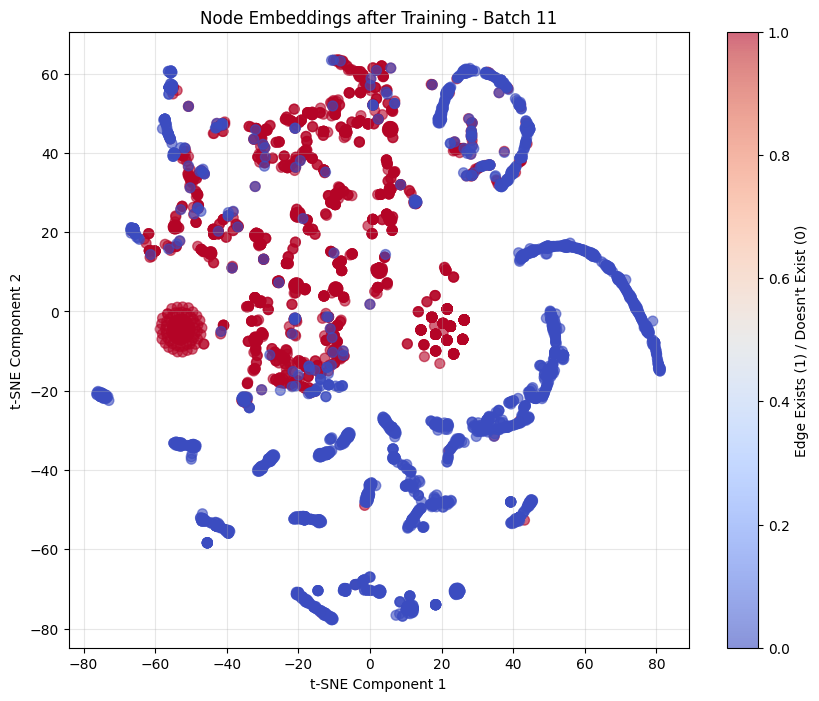

Average similarity for positive pairs: 0.9580
Average similarity for negative pairs: 0.1752
Separation (pos - neg): 0.7829


In [ ]:
for i, sample_batch in enumerate(temporal_batches[0:11]):
    title = f"Node Embeddings after Training - Batch {i+1}"
    visualize_embeddings(model, sample_batch, node_feats, title=title)

In [ ]:
len(temporal_batches)

2705

In [ ]:
edge_lookup = {}
for _, row in edges_train.iterrows():

    key = (row['src_id'], row['dst_id'], row['edge_type'])
    if key not in edge_lookup:
        edge_lookup[key] = []
    edge_lookup[key].append(row['timestamp'])

    key_rev = (row['dst_id'], row['src_id'], row['edge_type'])
    if key_rev not in edge_lookup:
        edge_lookup[key_rev] = []
    edge_lookup[key_rev].append(row['timestamp'])

In [ ]:
def predict_with_tgat(model, test_data, node_feats, edge_features):
    model.eval()

    test_edge_index = torch.tensor(
        np.array([test_data['src_id'].values, test_data['dst_id'].values]),
        dtype=torch.long
    )

    test_timestamps = (test_data['start_time'].values + test_data['end_time'].values) / 2

    edge_attr = torch.zeros(len(test_data), edge_features.shape[1]-1)

    with torch.no_grad():
        node_embeddings = model(
            node_feats,
            test_edge_index,
            edge_attr,
            test_timestamps
        )

    results = []
    for i, row in test_data.iterrows():
        src, dst = int(row['src_id']), int(row['dst_id'])

        if src >= len(node_embeddings) or dst >= len(node_embeddings):
            results.append(0)
            continue

        src_emb = node_embeddings[src]
        dst_emb = node_embeddings[dst]
        similarity = F.cosine_similarity(src_emb.unsqueeze(0), dst_emb.unsqueeze(0)).item() * 5.0

        probability = torch.sigmoid(torch.tensor(similarity)).item()
        results.append(probability)

    return results

In [ ]:
def derive_ground_truth(test_data, edges_train):
    """Derive ground truth labels for test data by checking if edges exist in training data"""
    print("Code in the derive_ground_truth method...")
    ground_truth = []

    for _, row in test_data.iterrows():
        src, dst, edge_type = row['src_id'], row['dst_id'], row['edge_type']
        start_bin, end_bin = row['start_bin'], row['end_bin']

        key = (src, dst, edge_type)
        if key in edge_lookup:
            exists = any(start_bin <= pd.cut([ts], bins=time_bin_edges, labels=False)[0] <= end_bin
                         for ts in edge_lookup[key] if not pd.isna(pd.cut([ts], bins=time_bin_edges, labels=False)[0]))
        else:
            exists = False

        ground_truth.append(1 if exists else 0)

    return ground_truth

In [ ]:
def visualize_prediction_results(model, test_data, node_feats, edge_features, ground_truth, predictions,
                               threshold=0.5, max_links=100, title="Link Prediction Results"):

    pred_labels = [1 if p > threshold else 0 for p in predictions]
    true_positive_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                           if gt == 1 and pred == 1]

    false_negative_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                            if gt == 1 and pred == 0]

    false_positive_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                            if gt == 0 and pred == 1]

    sample_size = max_links // 3

    sampled_indices = []


    if true_positive_indices:
        tp_sample = np.random.choice(true_positive_indices,
                                    min(sample_size, len(true_positive_indices)),
                                    replace=False)
        sampled_indices.extend(tp_sample)

    if false_negative_indices:
        fn_sample = np.random.choice(false_negative_indices,
                                    min(sample_size, len(false_negative_indices)),
                                    replace=False)
        sampled_indices.extend(fn_sample)

    if false_positive_indices:
        fp_sample = np.random.choice(false_positive_indices,
                                    min(sample_size, len(false_positive_indices)),
                                    replace=False)
        sampled_indices.extend(fp_sample)

    if not sampled_indices:
        print("No links to visualize.")
        return

    G = nx.Graph()

    for idx in sampled_indices:
        src = test_data.iloc[idx]['src_id']
        dst = test_data.iloc[idx]['dst_id']
        prob = predictions[idx]
        gt = ground_truth[idx]
        pred = pred_labels[idx]

        if gt == 1 and pred == 1:
            pred_type = "true_positive"
        elif gt == 1 and pred == 0:
            pred_type = "false_negative"
        elif gt == 0 and pred == 1:
            pred_type = "false_positive"
        else:
            pred_type = "true_negative"

        G.add_edge(src, dst,
                  weight=prob,
                  probability=f"{prob:.2f}",
                  ground_truth=gt,
                  prediction=pred,
                  pred_type=pred_type)

    edge_list = list(G.edges())
    if not edge_list:
        print("No edges to visualize.")
        return

    src_nodes = [e[0] for e in edge_list]
    dst_nodes = [e[1] for e in edge_list]

    all_src = np.array(src_nodes + dst_nodes)
    all_dst = np.array(dst_nodes + src_nodes)

    edge_index = torch.tensor(
        np.array([all_src, all_dst]),
        dtype=torch.long
    )

    model.eval()
    with torch.no_grad():
        edge_attr = torch.zeros(len(all_src), edge_features.shape[1]-1)

        mean_time = test_data['start_time'].mean()
        timestamps = torch.tensor([mean_time], dtype=torch.float)

        node_embeddings = model(
            node_feats,
            edge_index,
            edge_attr,
            timestamps
        )

    plt.figure(figsize=(14, 12))

    pos = nx.spring_layout(G, seed=42)

    node_colors = []
    for node in G.nodes():
        if node < len(node_embeddings):
            node_colors.append(node_embeddings[node][0].item())
        else:
            node_colors.append(0)

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        node_size=150,
        alpha=0.8
    )

    edge_colors = []
    edge_widths = []

    for u, v, data in G.edges(data=True):
        pred_type = data['pred_type']
        if pred_type == "true_positive":
            edge_colors.append('green')
            edge_widths.append(2.0)
        elif pred_type == "false_negative":
            edge_colors.append('red')
            edge_widths.append(1.5)
        elif pred_type == "false_positive":
            edge_colors.append('orange')
            edge_widths.append(1.5)
        else:
            edge_colors.append('blue')
            edge_widths.append(1.0)

    edges = nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.7
    )

    high_conf_edges = {(u, v): f"{G[u][v]['probability']}"
                      for u, v in G.edges()
                      if float(G[u][v]['probability']) > 0.8 or float(G[u][v]['probability']) < 0.2}

    if len(high_conf_edges) < 50:
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=high_conf_edges,
            font_size=8
        )

    if len(G.nodes()) < 50:
        nx.draw_networkx_labels(G, pos, font_size=8)
    else:
        degrees = dict(G.degree())
        top_nodes = {node: str(node) for node, degree in degrees.items()
                    if degree > np.percentile(list(degrees.values()), 75)}
        nx.draw_networkx_labels(G, pos, labels=top_nodes, font_size=8)

    plt.colorbar(nodes, label="Node Embedding Value")

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='True Positive (Correct Link)'),
        Line2D([0], [0], color='red', lw=2, label='False Negative (Missed Link)'),
        Line2D([0], [0], color='orange', lw=2, label='False Positive (False Link)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f"{title} (showing {len(G.edges())} links)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    tp = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'true_positive')
    fn = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'false_negative')
    fp = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'false_positive')

    print(f"Visualization Statistics:")
    print(f"Total links shown: {len(G.edges())}")
    print(f"Correctly predicted links (True Positives): {tp}")
    print(f"Missed links (False Negatives): {fn}")
    print(f"Falsely predicted links (False Positives): {fp}")

    total_tp = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 1 and pred == 1)
    total_fn = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 1 and pred == 0)
    total_fp = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 0 and pred == 1)

    print(f"\nOverall Model Performance:")
    print(f"Total True Positives: {total_tp}")
    print(f"Total False Negatives: {total_fn}")
    print(f"Total False Positives: {total_fp}")
    if total_tp + total_fn > 0:
        recall = total_tp / (total_tp + total_fn)
        print(f"Recall: {recall:.4f}")
    if total_tp + total_fp > 0:
        precision = total_tp / (total_tp + total_fp)
        print(f"Precision: {precision:.4f}")

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
model.load_state_dict(torch.load('best_tgat_model.pth'))
model_probs = predict_with_tgat(model, test_data, node_feats, edge_features)
ground_truth = derive_ground_truth(test_data, edges_train)




Code in the derive_ground_truth method...



Results with fixed threshold (0.5):
AUC Score: 0.6580
Accuracy: 0.7677
F1 Score: 0.8666


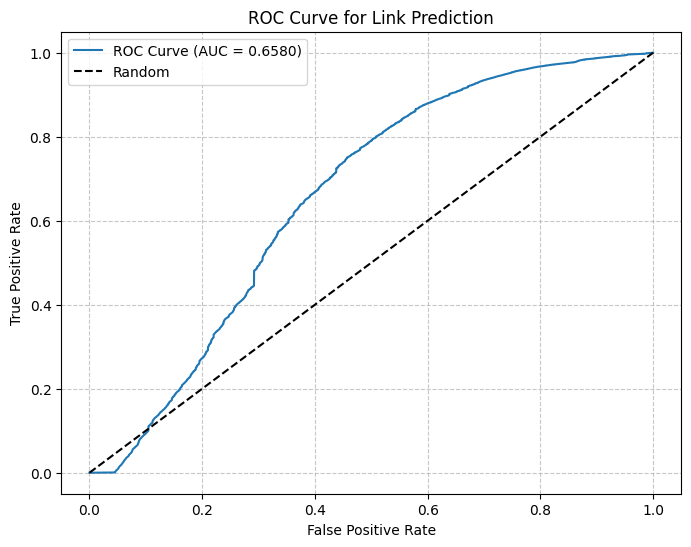

<Figure size 800x600 with 0 Axes>

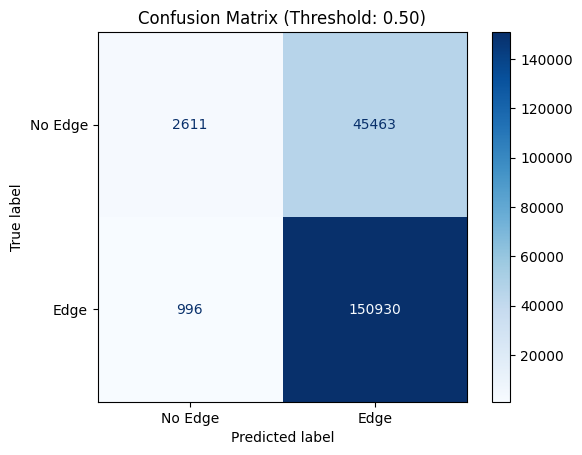

In [ ]:
fixed_threshold = 0.5
final_predictions = [1 if p > fixed_threshold else 0 for p in model_probs]

accuracy = accuracy_score(ground_truth, final_predictions)
f1 = f1_score(ground_truth, final_predictions)
auc = roc_auc_score(ground_truth, model_probs)

results = {
    'threshold': fixed_threshold,
    'auc_score': auc,
    'accuracy': accuracy,
    'f1_score': f1,
    'num_test_samples': len(test_data)
}

print("\nResults with fixed threshold (0.5):")
print(f"AUC Score: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

fpr, tpr, _ = roc_curve(ground_truth, model_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Link Prediction')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

cm = confusion_matrix(ground_truth, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Edge', 'Edge'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold: {fixed_threshold:.2f})')
plt.show()

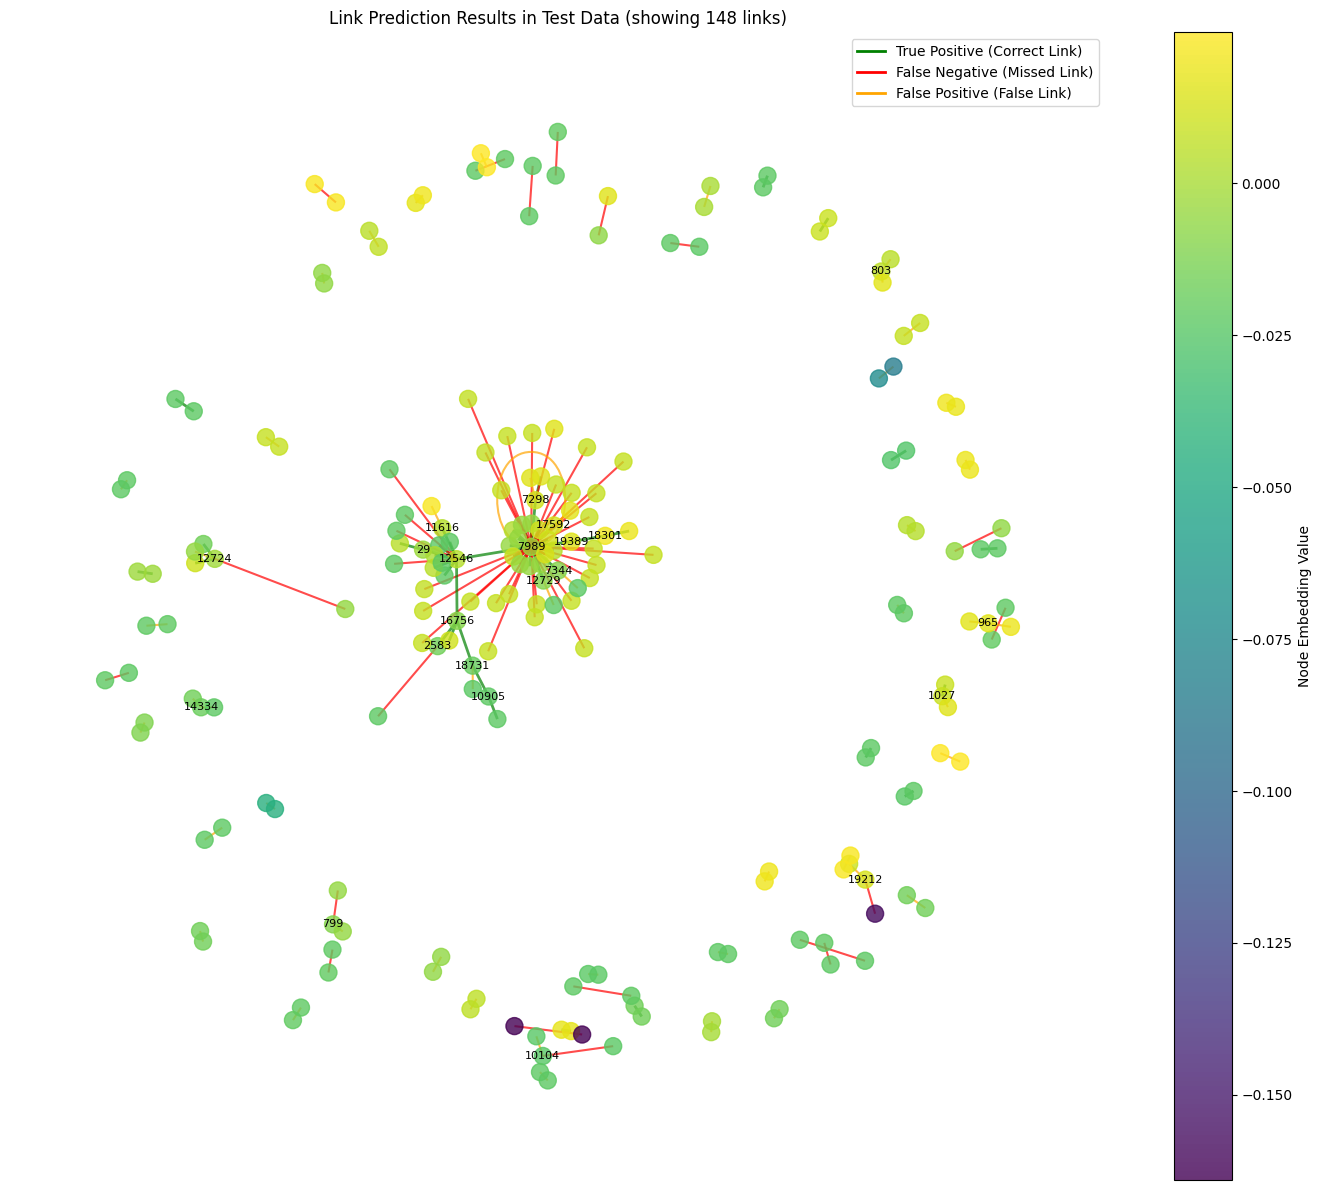

Visualization Statistics:
Total links shown: 148
Correctly predicted links (True Positives): 49
Missed links (False Negatives): 50
Falsely predicted links (False Positives): 49

Overall Model Performance:
Total True Positives: 150930
Total False Negatives: 996
Total False Positives: 45463
Recall: 0.9934
Precision: 0.7685


In [ ]:
visualize_prediction_results(
    model,
    test_data,
    node_feats,
    edge_features,
    ground_truth,
    model_probs,
    threshold=fixed_threshold,
    max_links=150,
    title="Link Prediction Results in Test Data"
)

In [ ]:
predictions_df = pd.DataFrame({
    'src_id': test_data['src_id'],
    'dst_id': test_data['dst_id'],
    'edge_type': test_data['edge_type'],
    'predicted_probability': model_probs,
    'predicted_label': final_predictions,
    'ground_truth': ground_truth,
    'correct_prediction': [1 if pred == true else 0 for pred, true in zip(final_predictions, ground_truth)]
})
predictions_df.to_csv('tgat_model_results.csv', index=False)

In [ ]:
assert set(test_data['src_id']).issubset(set(edges_train['src_id'])), "Test nodes not in training set!"

print("Train time range:", edges_train['timestamp'].min(), edges_train['timestamp'].max())
print("Test time range:", test_data['start_time'].min(), test_data['end_time'].max())

Train time range: 1413662400 1494705600
Test time range: 1494581188 1499122550


In [ ]:
assert all(test_data['end_time'] > edges_train['timestamp'].max()), "Some test queries are not in the future!"


In [ ]:
train_end_time = edges_train['timestamp'].max()
overlap_ratio = (test_data['start_time'] < train_end_time).mean()
print(f" %{overlap_ratio*100:.2f} of test queries overlap with training time")

 %1.51 of test queries overlap with training time


In [ ]:
clean_test = test_data[test_data['start_time'] >= train_end_time]
clean_probs = predict_with_tgat(model, clean_test, node_feats, edge_features)
clean_truth = derive_ground_truth(clean_test, edges_train)


Code in the derive_ground_truth method...



Temporal Leakage Analysis
Original test size: 200000
Clean test size: 196982 (98.5% of original)
Clean test AUC (no leakage): 0.6597
AUC difference: -0.0018
Accuracy: 0.7711
F1 Score: 0.8688


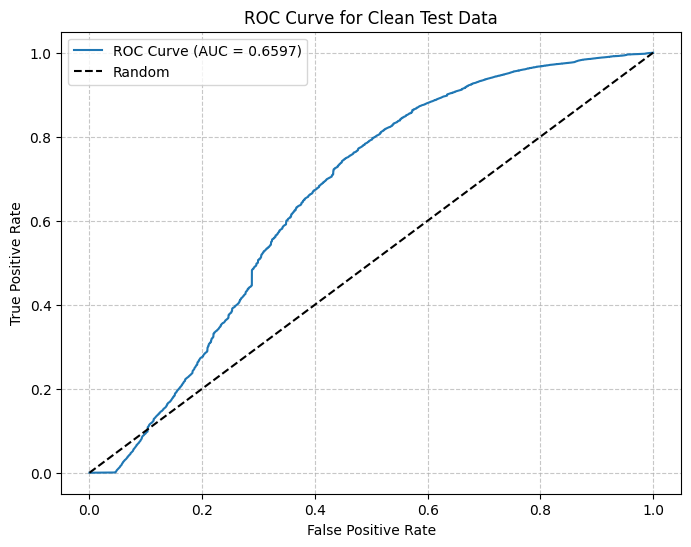

<Figure size 800x600 with 0 Axes>

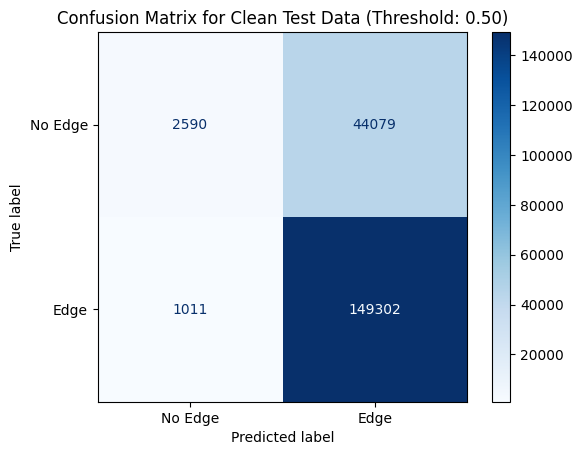

In [ ]:
fixed_threshold_2 = 0.5
final_predictions_2 = [1 if p > fixed_threshold_2 else 0 for p in clean_probs]

clean_auc = roc_auc_score(clean_truth, clean_probs)
f1_2 = f1_score(clean_truth, final_predictions_2)
accuracy_2 = accuracy_score(clean_truth, final_predictions_2)

print("\nTemporal Leakage Analysis")
print(f"Original test size: {len(test_data)}")
print(f"Clean test size: {len(clean_test)} ({len(clean_test)/len(test_data):.1%} of original)")
print(f"Clean test AUC (no leakage): {clean_auc:.4f}")
print(f"AUC difference: {auc-clean_auc:+.4f}")
print(f"Accuracy: {accuracy_2:.4f}")
print(f"F1 Score: {f1_2:.4f}")

fpr, tpr, _ = roc_curve(clean_truth, clean_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {clean_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Clean Test Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

cm = confusion_matrix(clean_truth, final_predictions_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Edge', 'Edge'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for Clean Test Data (Threshold: {fixed_threshold_2:.2f})')
plt.show()


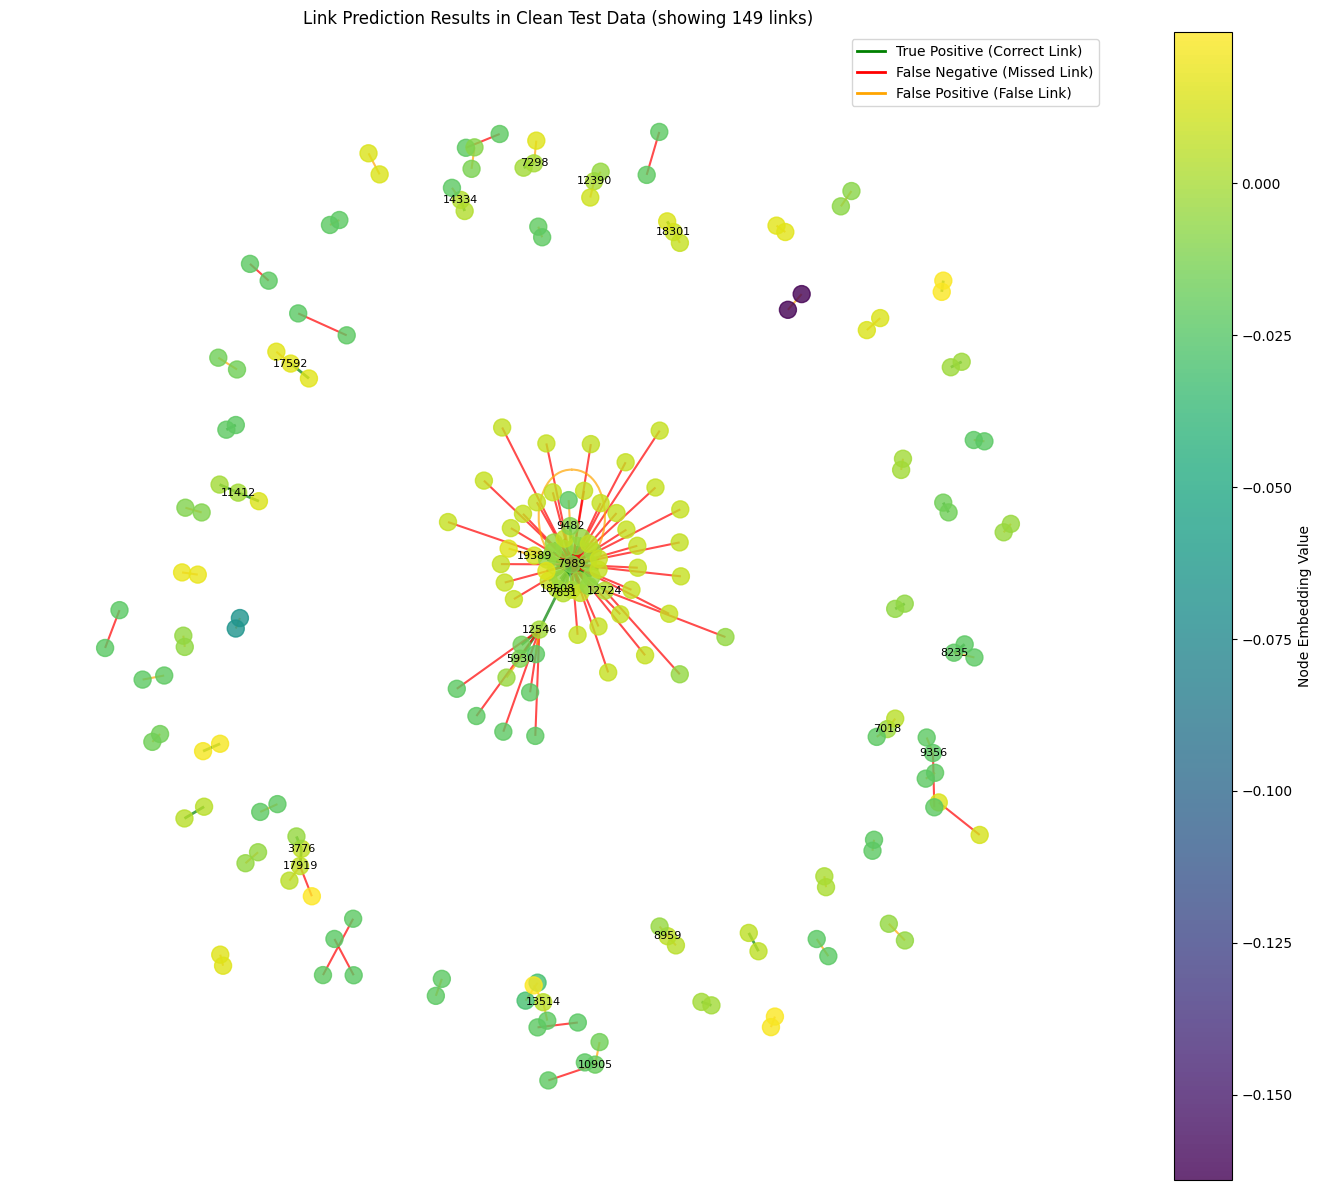

Visualization Statistics:
Total links shown: 149
Correctly predicted links (True Positives): 49
Missed links (False Negatives): 50
Falsely predicted links (False Positives): 50

Overall Model Performance:
Total True Positives: 149302
Total False Negatives: 1011
Total False Positives: 44079
Recall: 0.9933
Precision: 0.7721


In [ ]:
visualize_prediction_results(
    model,
    clean_test,
    node_feats,
    edge_features,
    clean_truth,
    clean_probs,
    threshold=fixed_threshold_2,
    max_links=150,
    title="Link Prediction Results in Clean Test Data"
)

In [ ]:
print("Test data size:", len(test_data))

Test data size: 200000


In [ ]:
predictions_df_2 = pd.DataFrame({
    'src_id': clean_test['src_id'],
    'dst_id': clean_test['dst_id'],
    'edge_type': clean_test['edge_type'],
    'predicted_probability': clean_probs,
    'predicted_label': final_predictions_2,
    'ground_truth': clean_truth,
    'correct_prediction': [1 if pred == true else 0 for pred, true in zip(final_predictions_2, clean_truth)]
})
predictions_df_2.to_csv('output_A_clean_tgan.csv', index=False, header=False)
